### 0. Imports

In [81]:
%load_ext autoreload
%autoreload 2

# Data transformation
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np


# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Progress loops
# -----------------------------------------------------------------------
from tqdm import tqdm

# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs


# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr
from scipy.stats.mstats import winsorize
from scipy.stats import trim_mean

# work with serialized pickle files
# -----------------------------------------------------------------------
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Intro to EDA notebook and data import

## 1.1 Introduction

The purporse of this EDA notebook is to further explore data at its most granular level to understand it more deeply, as we could yet extract some value from it before aggregation to the desired levels. This EDA will additionally allow to find insights hidden in the data that could:
- Bring business value 
- Inform some transformations or configuration for the upcoming machine learning models
- Shed light into data quality problems

A business goal has not yet been decided and therefore this phase is more useful than ever to discover what are the most profitable patterns to chase in order to improve the business.

## 1.2 Data import

In [82]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. EDA

## 2.1 Univariate data analysis - row level

In [83]:
visualizador = sp.Visualizador(global_superstore.drop(columns=["row_id","order_id","order_date","ship_date","customer_id","customer_name","product_name","product_id"]))

### 2.1.1 Numerical features

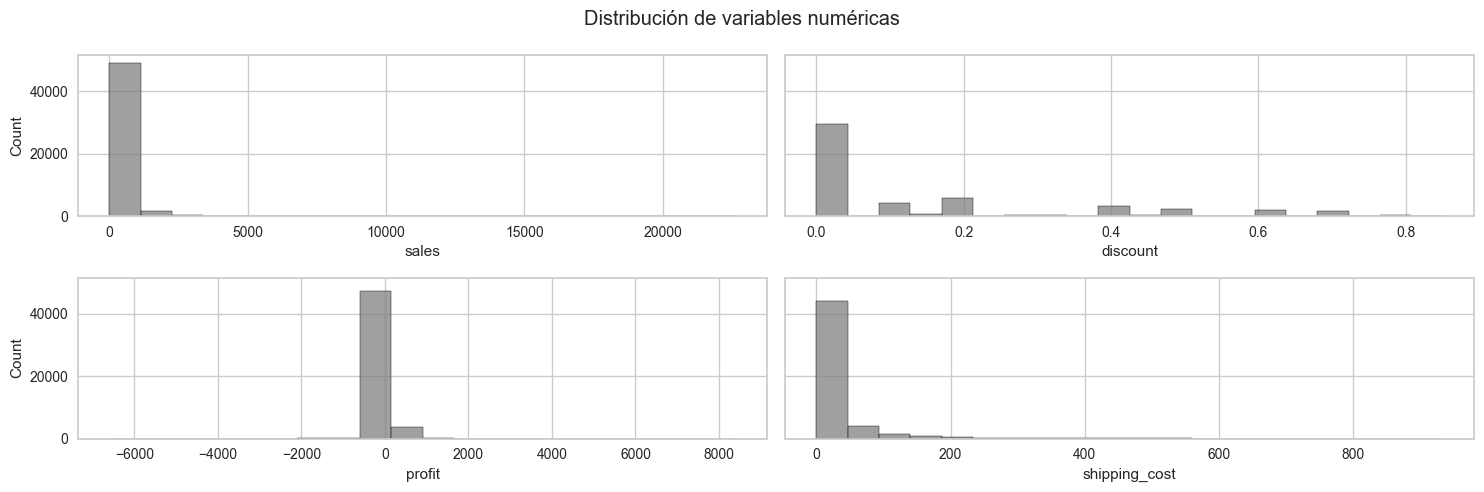

In [84]:
visualizador.plot_numericas()

Sales, profit and shipping costs all have heavily skewed values. These outliers will have to be treated during preprocessing for both clustering and regression models, especially for the formers.

Discounts are mostly low, although there are some very high discounts, presumably for excellent customers or for very special promotions in certain products.

Although sales and shipping costs are always positive, profits are skewed on both ends, with a large amount of profits being negative. Let us observe those values in particular, trimming both ends by 1%:

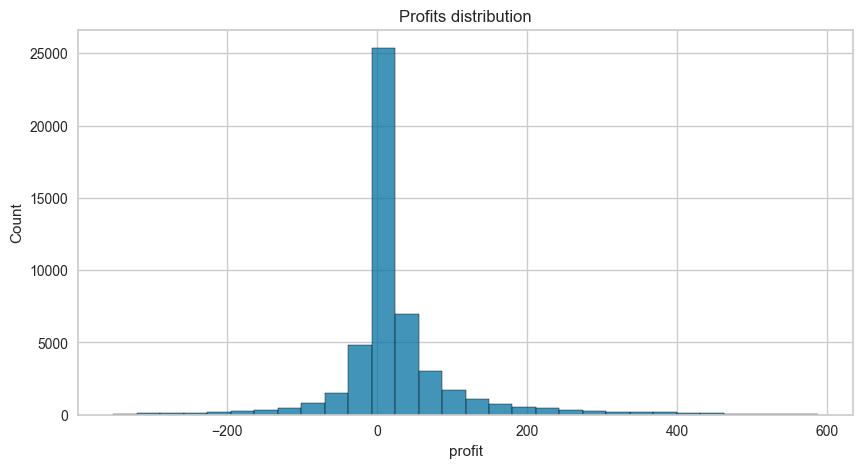

count       mean         std       min  25%   50%    75%       max
profit  51290.0  28.610982  174.340972 -6599.978  0.0  9.24  36.81  8399.976

In [85]:
lower_bound = np.percentile(global_superstore['profit'], 1)  # 1st percentile
upper_bound = np.percentile(global_superstore['profit'], 99)  # 99th percentile


plt.figure(figsize=(10,5))
plt.title("Profits distribution")
sns.histplot(data=global_superstore[global_superstore["profit"].between(lower_bound,upper_bound)],
             x="profit", bins=30)
plt.show()

global_superstore[["profit"]].describe().T

This means that a lot of products bring negative profits on their own. Does the same happen for orders?

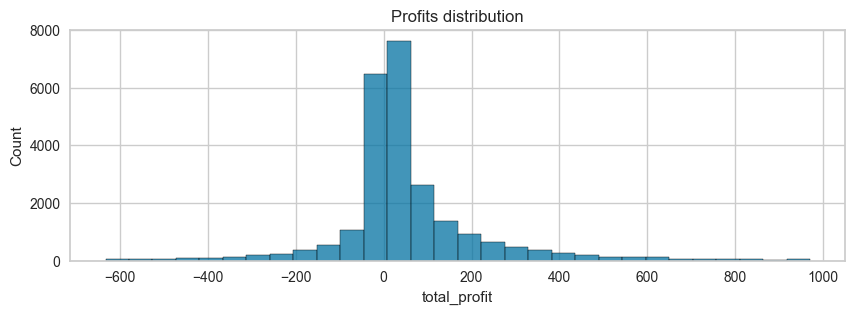

count       mean         std        min  25%    50%      75%  \
total_profit  25035.0  58.616229  275.302973 -6892.3748  0.0  20.07  89.1737   

                    max  
total_profit  8762.3891

In [86]:
orders_profit = global_superstore.groupby(["order_id"]).agg(total_profit=("profit","sum"))

# clip chart by 1 and 99 percentiles
lower_bound = np.percentile(orders_profit['total_profit'], 1)  # 1st percentile
upper_bound = np.percentile(orders_profit['total_profit'], 99)  # 99th percentile

# plot chart
plt.figure(figsize=(10,3))
plt.title("Profits distribution")
sns.histplot(data=orders_profit[orders_profit["total_profit"].between(lower_bound,upper_bound)],
             x="total_profit", bins=30)
plt.show()

orders_profit.describe().T

For orders, the range gets wider, but the mean and median profits increase. Which means that not all orders are profitable, but at least the loss from individual products gets somehow compensated.

### 2.1.2 Categorical features

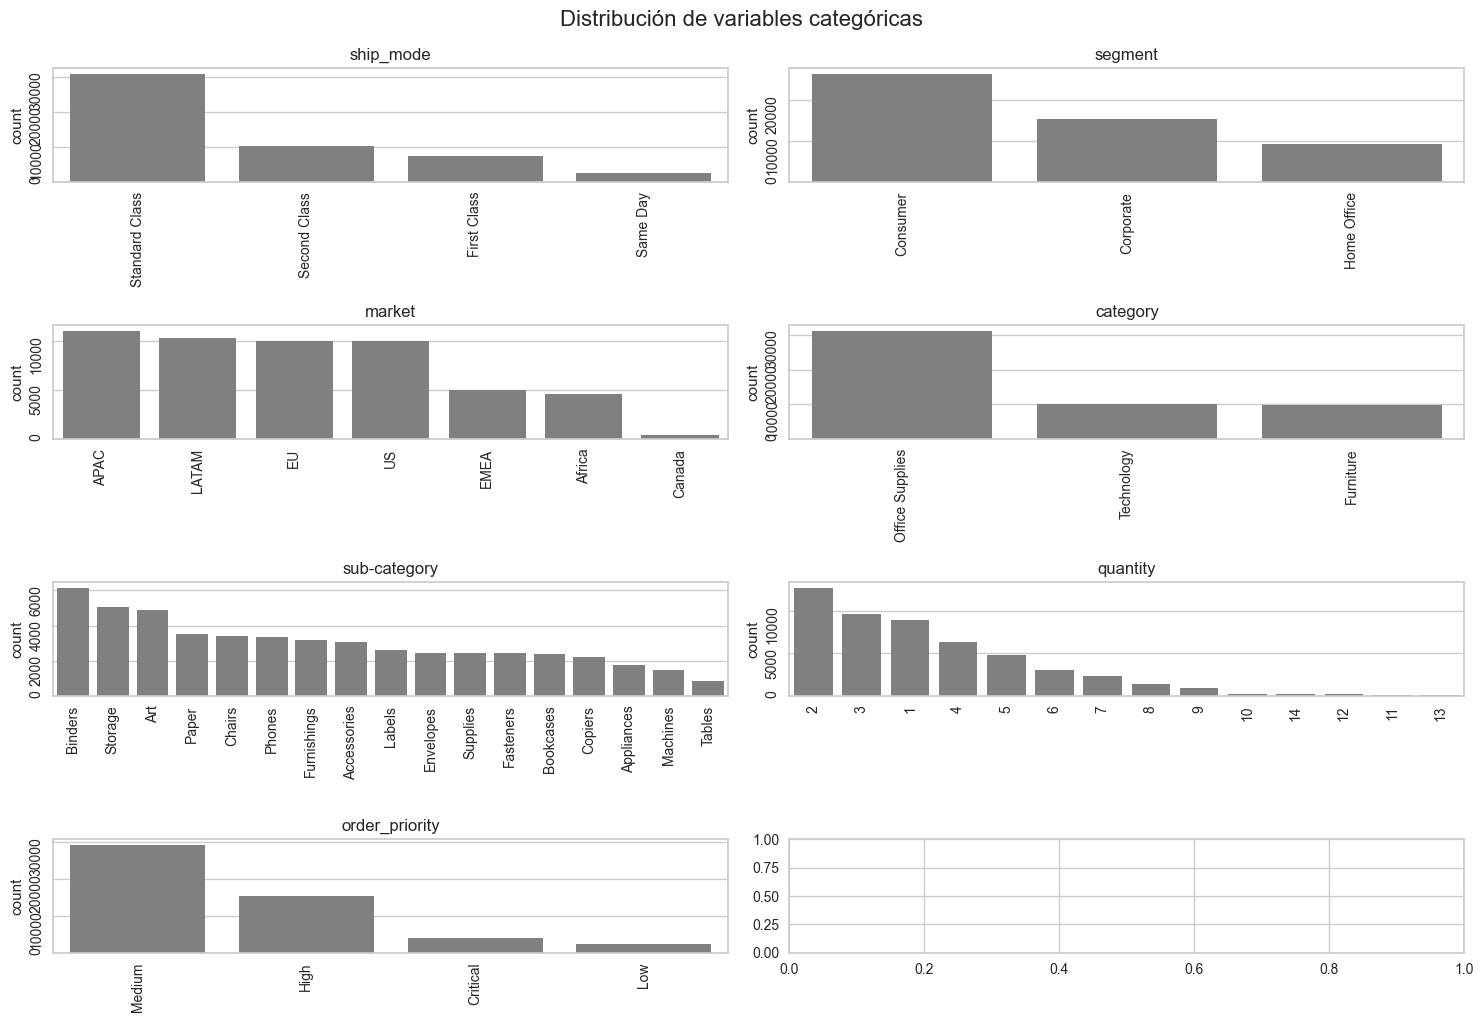

In [87]:
visualizador.plot_categoricas(tamano_grafica=(15,10))

**Ship_mode** 

Seems to follow a logical order in its frequency, which is ideal for its encoding into frequency. Category representations are within healty ranges.

**Segment** 

Gives indication that about half of products are bought for consumers, while the remaining are bought for professional use.

**Market** 

Follows a uniform distribution. However, there is a mistake with the categories EU and Africa, as they really are part of EMEA. 

There is no way to tell whether EU is not included to make it a distinction, or the same goes for Africa. It could be that after a certain time there is a change in typology, however we see below that its not the case. We leave it as is to see if they should be grouped or not. Canada gets grouped inside US due to its low relative representation.

In [88]:
# group Canada inside US
global_superstore["market"] = np.where(global_superstore["market"]=="Canada","US",global_superstore["market"])

# show EU, EMEA and Africa time ranges
(global_superstore.groupby("market")[["order_date"]].agg(["min","max"]).T)[["EU","EMEA","Africa"]]

market                 EU       EMEA     Africa
order_date min 2011-01-01 2011-01-01 2011-01-01
           max 2014-12-31 2014-12-31 2014-12-31

**Category** of products are dominated mostly by Office Supplies.

**Subcategory** starts to show a fairly high cardinality. It is ncessary to check its value counts.

In [89]:
global_superstore[["sub-category"]].value_counts().reset_index().assign(pct=lambda row: row["count"]/global_superstore.shape[0]*100)

sub-category  count        pct
0       Binders   6152  11.994541
1       Storage   5059   9.863521
2           Art   4883   9.520374
3         Paper   3538   6.898031
4        Chairs   3434   6.695262
5        Phones   3357   6.545136
6   Furnishings   3170   6.180542
7   Accessories   3075   5.995321
8        Labels   2606   5.080912
9     Envelopes   2435   4.747514
10     Supplies   2425   4.728017
11    Fasteners   2420   4.718269
12    Bookcases   2411   4.700721
13      Copiers   2223   4.334178
14   Appliances   1755   3.421720
15     Machines   1486   2.897251
16       Tables    861   1.678690

It looks like the least frequent, tables, has enough representation. However, if the data divided, it should be rechecked.

**quantity** should be grouped for quanitities beyond 9 products if kept as a category. However, although it has little number of unique values, these will grow as they get aggregated. For now, converting back to number:

In [90]:
global_superstore["quantity"] = global_superstore["quantity"].astype(int)
# global_superstore["quantity"] = np.where(global_superstore["quantity"] >=9, "9 or more",global_superstore["quantity"])

**order priority** has good representation. Their categories follow a logical frequency distribution except for low priorities.

## 2.2 Multivariate analysis

Analysis of how features interact with each other at row level (no aggregation) and different levels of aggregation

### 2.2.1 Row level analysis

Interaction between features at the row level information available without aggregation.

**Q:** Does price decrease or discount increase with quantity from a general point of view?

<Axes: >

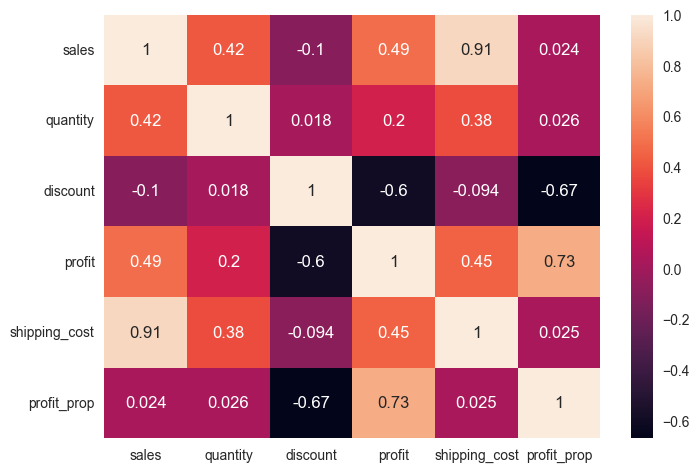

In [91]:
# create profit % feature to add into analysis
global_superstore["profit_prop"] = global_superstore["profit"] / global_superstore["sales"]


# check correlations
sns.heatmap(global_superstore.corr(numeric_only=True, method="spearman"),annot=True)

From this matrix, there are obvious positive correlations:
- Profit and sales
- Sales and quantity
- Profit margin (profit_prop) with respect to sales, quantity, etc

But there are 2 interesting correlations:
1. Shipping cost and sales: Shipping costs are related to how expensive the whole set of bought items is.
2. Sales has a slighly negative correlation with discount, which suggests that discounts have already been applied.

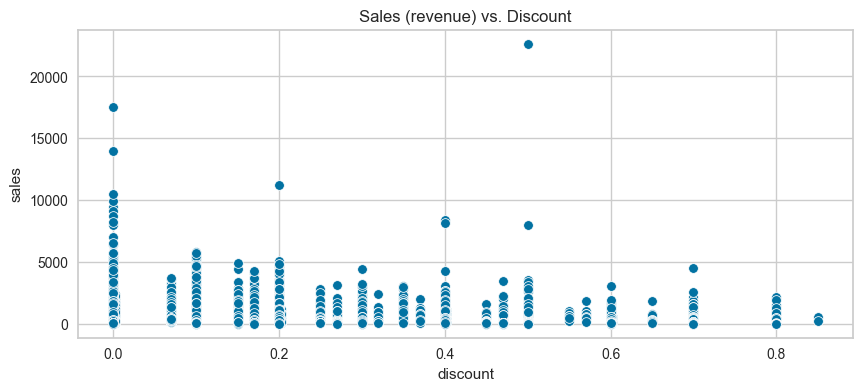

In [92]:
plt.figure(figsize=(10,4))
plt.title("Sales (revenue) vs. Discount")
sns.scatterplot(data=global_superstore,
                y="sales",
                x="discount")

plt.show()

Seeing this, the most correct way to calculate discounted prices to later aggregate them in a way that allows to calculate discount % is the following:

In [210]:
# create discounted price columns
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]

# create original cost column
global_superstore["original_price"] = global_superstore["discounted_price"] + global_superstore["sales"]

Shipping costs are very correlated with sales, and they are also correlated with discounts in almost an exact same pearson correlation and shape:

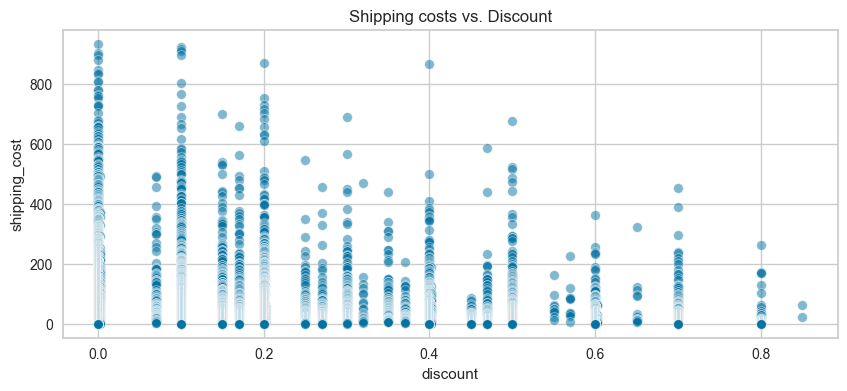

In [94]:
plt.figure(figsize=(10,4))
plt.title("Shipping costs vs. Discount")
sns.scatterplot(data=global_superstore,
                y="shipping_cost",
                x="discount", alpha=0.5)

plt.show()

This points to the fact that shipping costs could be discounted by discounts too. Let us quickly inspect all numerical relationships via pairplot:

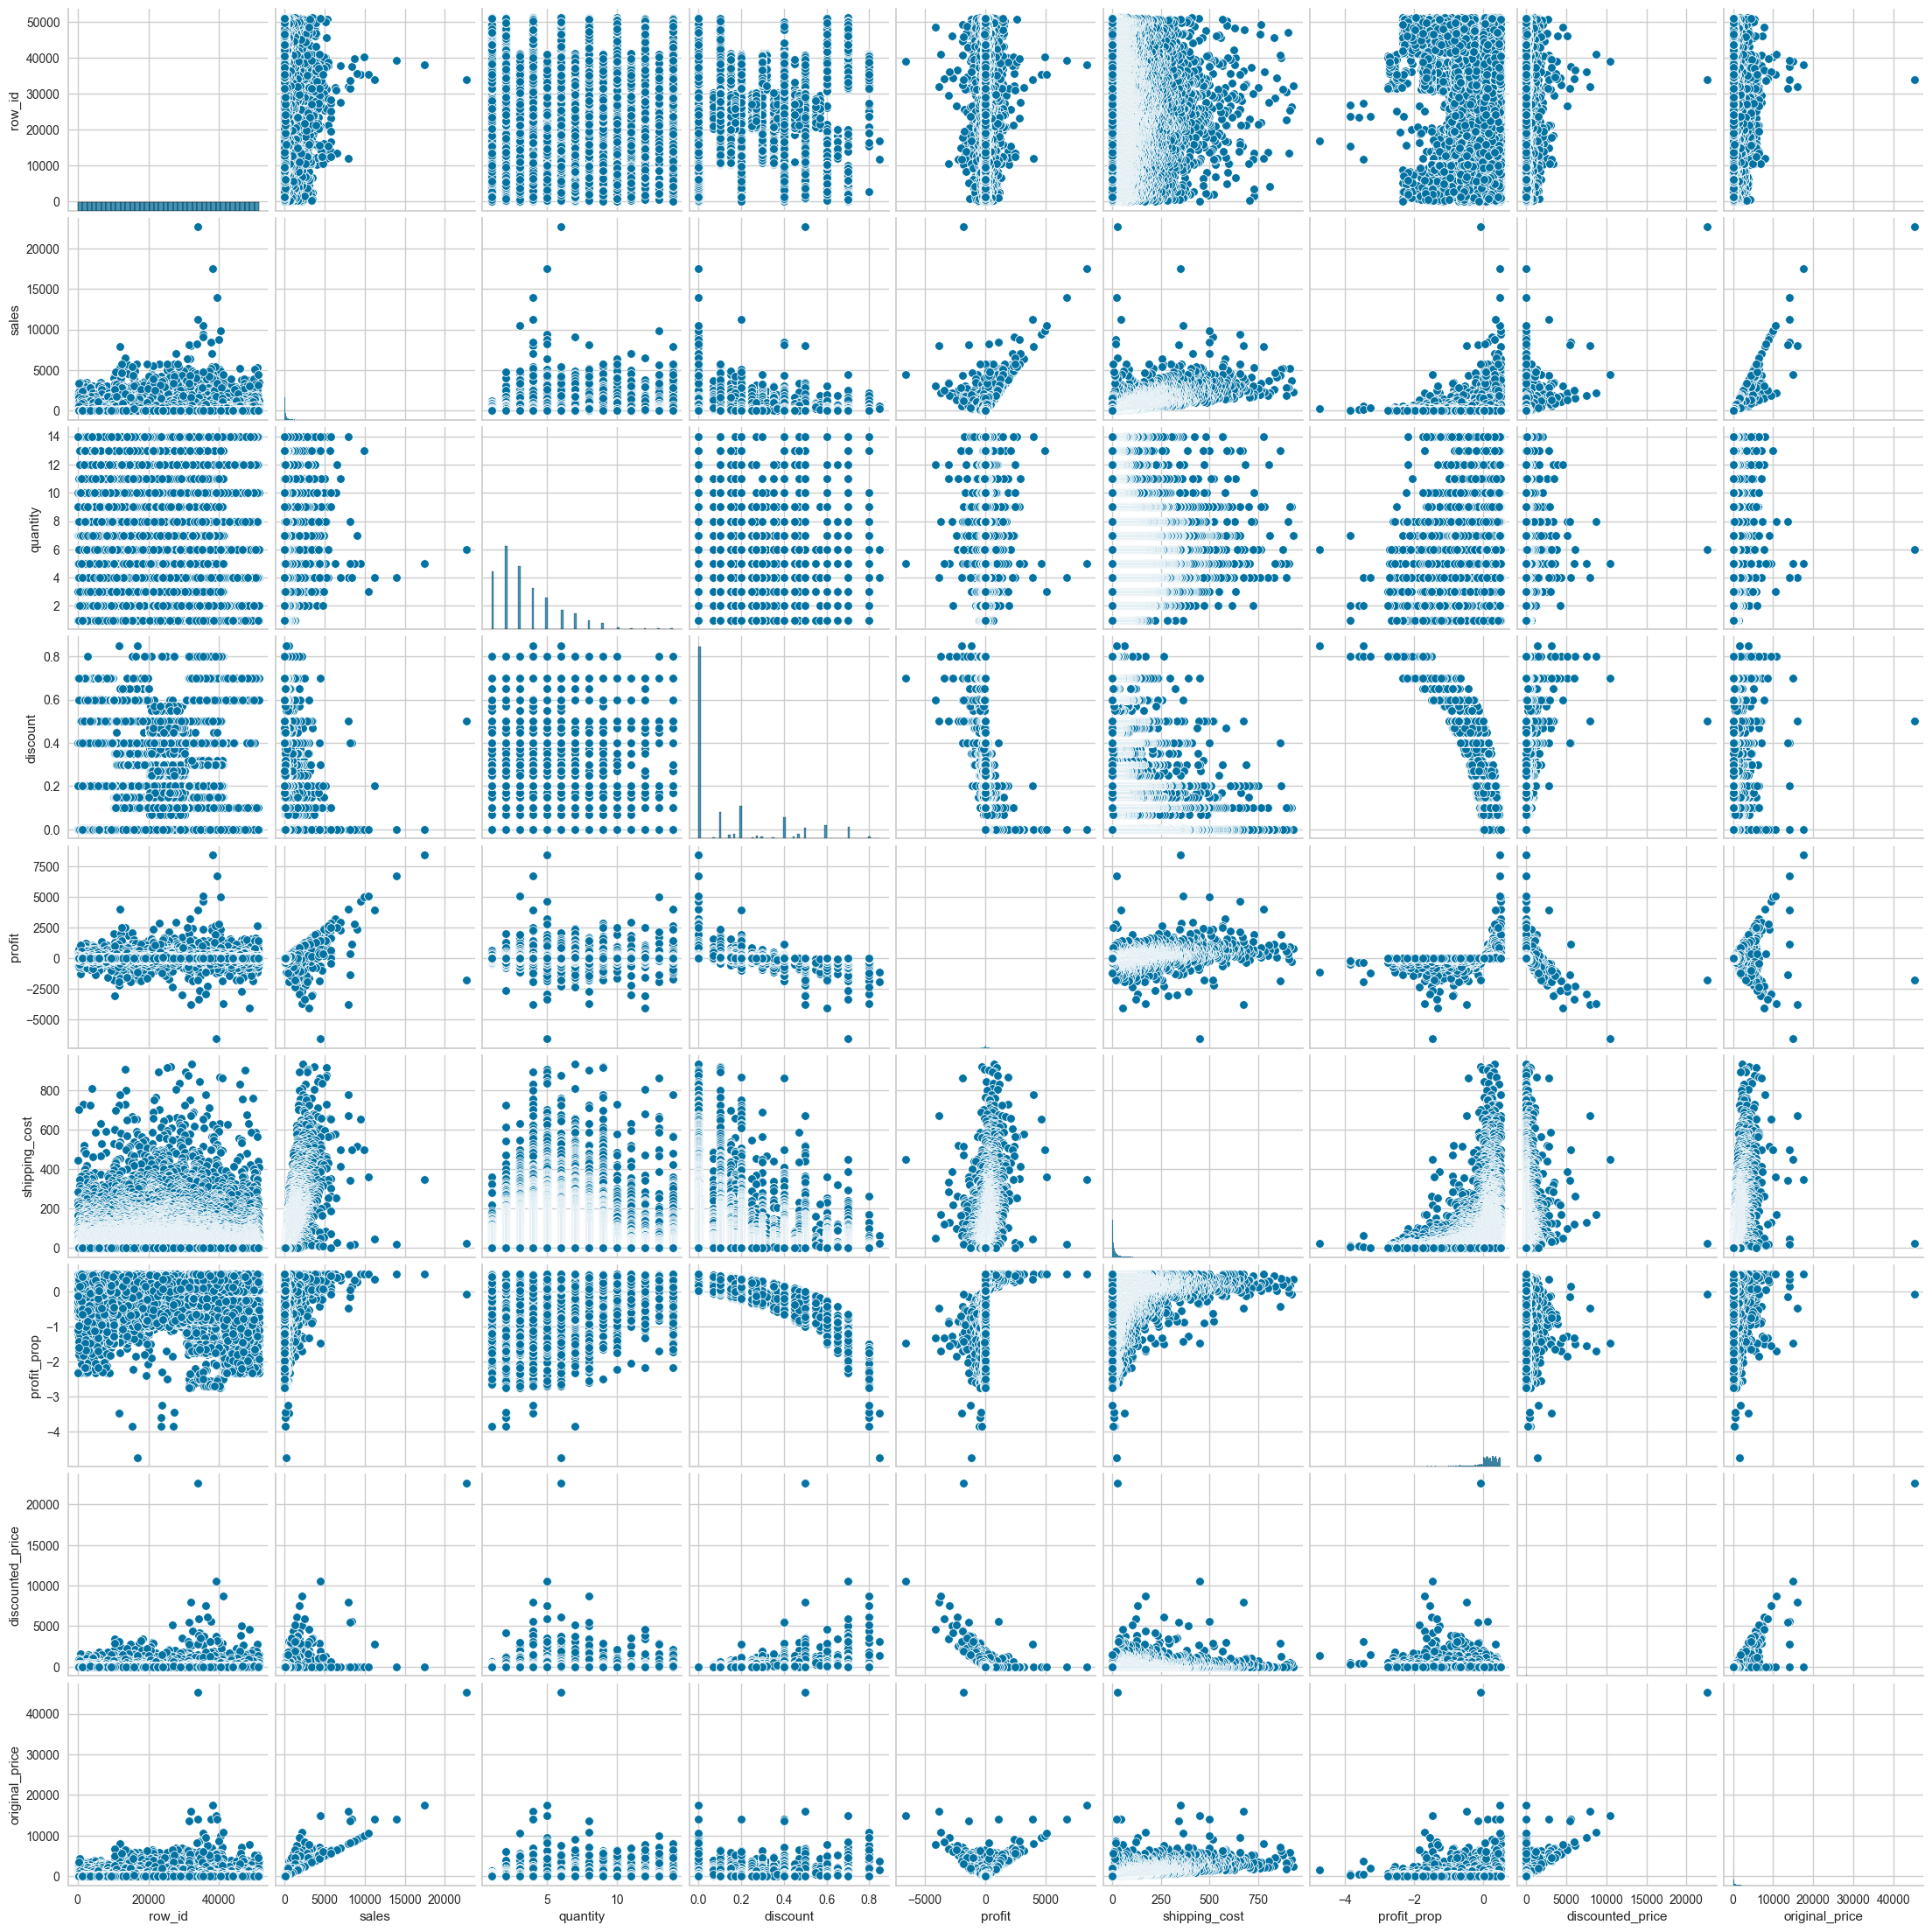

In [95]:
sns.pairplot(global_superstore)

Above, the negative correlation between discounts and profits is identified. Zoomin in into it:

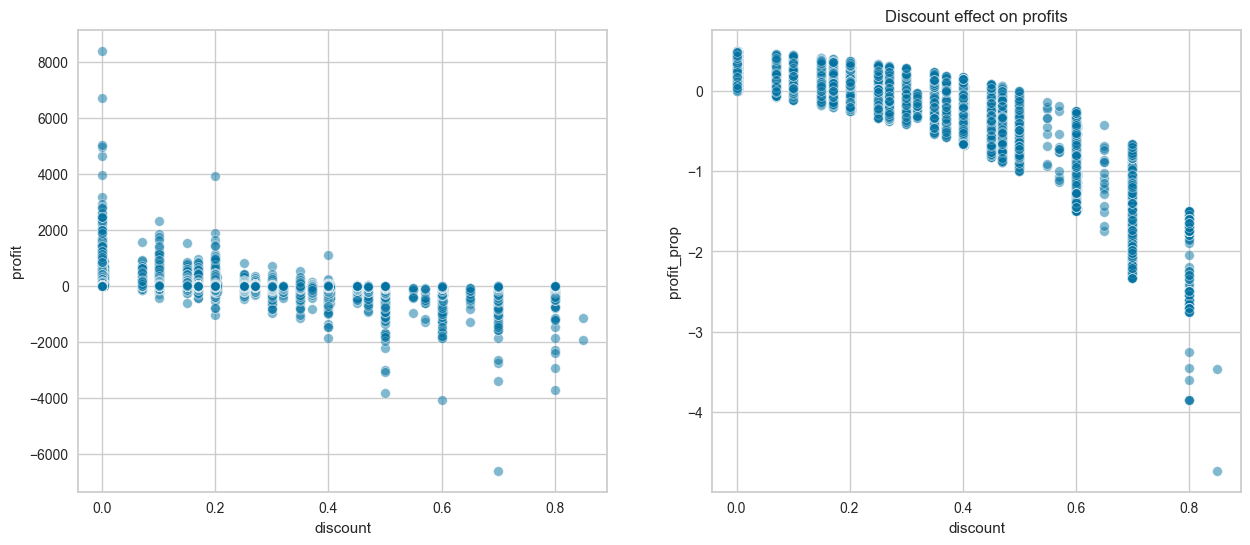

In [96]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

plt.title("Discount effect on profits")
sns.scatterplot(data=global_superstore,
                y="profit",
                x="discount", alpha=0.5, ax=axes[0])

sns.scatterplot(data=global_superstore,
                y="profit_prop",
                x="discount", alpha=0.5, ax=axes[1])

plt.show()

Excessive discounts eat away the profit margins obtained from products. They can be assumed to a certain level, but beyond 40-50% they always result in losses. Therefore, an important insight has been obtained, which should be acted upon by uncovering why such high discounts are given; is this a recurring pattern due to seasonal offers? is this to get rid of excessive stock? is this performed to attract certain customers?

Besides this, we see that original_price column, which makes reference the total revenue from the item (price per unit x quantity), is uncorrelated with discounts:

<Axes: xlabel='discount', ylabel='original_price'>

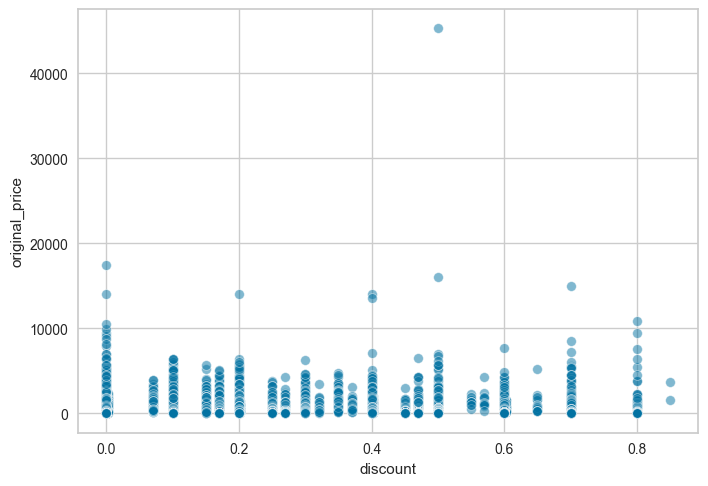

In [179]:
sns.scatterplot(data=global_superstore,
                y="original_price",
                x="discount", alpha=0.5)

#### 2.2.1.1 Calculation of additional metrics

Original price per unit:

In [ ]:
global_superstore["original_ppu"] = (global_superstore["sales"] + global_superstore["discounted_price"]) / global_superstore["quantity"]

Checking wether this calculation is correct with products that have both > 0% discount and 0 discount, On the first and last row above, we see that the original price calculated is correct.:

In [ ]:
global_superstore.loc[global_superstore["product_name"].str.startswith("#10 Gummed Flap White Envelopes, 100/Box"),["quantity","sales","discount","original_price","original_ppu"]]

quantity   sales  discount  original_price  original_ppu
48240         2   8.260       0.0            8.26          4.13
48248         4  16.520       0.0           16.52          4.13
48586         3   9.912       0.2           12.39          4.13
51189         2   6.608       0.2            8.26          4.13

Boolean for discounts

In [99]:
global_superstore["is_discount"] = np.where(global_superstore["discount"] > 0,1,0)


Original price stemmed from the check above about discounts already discounted.

In [100]:
global_superstore["original_price"] = global_superstore["discounted_price"] + global_superstore["sales"]

Stemmed from the hypothesis that shipping also gets discount.

In [101]:
global_superstore["discounted_shipping"] = global_superstore["shipping_cost"]/(1-global_superstore["discount"]) - global_superstore["shipping_cost"]

Given that profits are always positive when discounts are 0, then profits are taken away by discounted price and shipping:

In [102]:
global_superstore["profit_before_discounts"] = (global_superstore["discounted_shipping"] + 
                                                global_superstore["discounted_price"] + global_superstore["profit"])

Calculate profit per unit, before and after discount.

In [103]:
global_superstore["margin_wo_discount"] = global_superstore["profit_before_discounts"] / global_superstore["quantity"]
global_superstore["margin_discount"] = global_superstore["profit"] / global_superstore["quantity"]

In [213]:
# margin % before discount
global_superstore["margin_pct_wo_discount_price"] = global_superstore["margin_wo_discount"] / global_superstore["original_ppu"]

#### 2.2.1.2 Questions to drive the analysis

**Q**: What is the impact of discounts in total profit?

In [104]:
# differentiate positive and negative profits
global_superstore["neg_profit"] = np.where(global_superstore["profit"] < 0, global_superstore["profit"], 0)
global_superstore["pos_profit"] = np.where(global_superstore["profit"] > 0, global_superstore["profit"], 0)

# put together for plotting and melt
yearly_profits = global_superstore.set_index("order_date")[["pos_profit", "neg_profit"]].resample("YE").sum().reset_index()
yearly_profits["neg_profit"] = np.abs(yearly_profits["neg_profit"])

melted_profits = yearly_profits.melt(id_vars="order_date", var_name="Profit_Type", value_name="Profit")

Plot the impact of negative profits (losses) due to discounts:

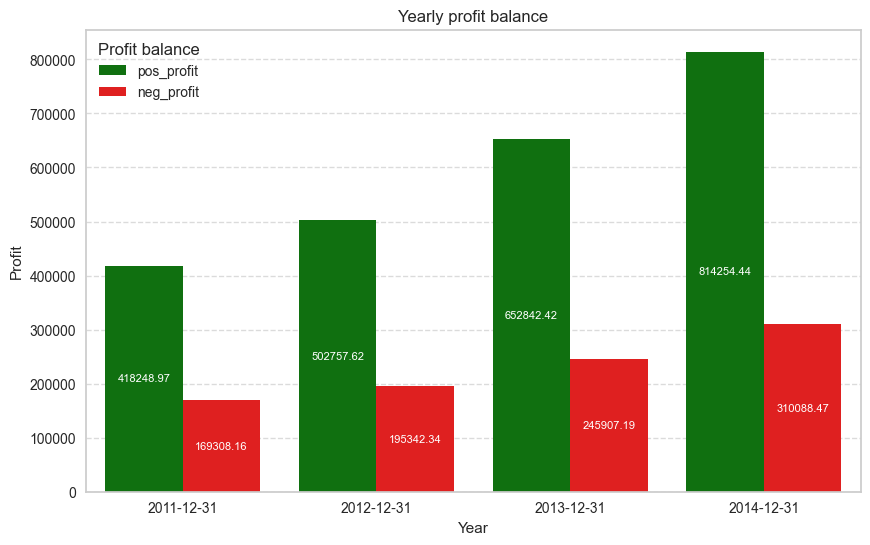

In [105]:
# set a color palette
palette = {"pos_profit": "green", "neg_profit": "red"}

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Yearly profit balance")
sns.barplot(
    data=melted_profits,
    x="order_date",
    y="Profit",
    hue="Profit_Type",
    palette=palette,
    ax=ax
)

plt.xlabel("Year")
plt.ylabel("Profit")
plt.legend(title="Profit balance", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
dvs.plot_bar_labels(ax)
plt.show()


**Q:** Are discounts designed for small purchases to attract bigger revenue purchases?

No. Yearly revenue from sales over 5000 is marginal compared to that of small revenue:

In [106]:
yearly_profits_under_5000 = global_superstore[global_superstore["sales"]<5000].set_index("order_date")[["sales","profit"]].resample("YE").sum()
yearly_profits_over_5000 = global_superstore[global_superstore["sales"]>5000].set_index("order_date")[["sales","profit"]].resample("YE").sum()

print("Small 'sales' purchases revenue and profit:")
display(yearly_profits_under_5000)

print("\nBig 'sales' purchases revenue and profit:")
yearly_profits_over_5000

Small 'sales' purchases revenue and profit:


sales        profit
order_date                            
2011-12-31  2.174397e+06  234708.28524
2012-12-31  2.637381e+06  299417.56010
2013-12-31  3.307675e+06  374167.74378
2014-12-31  4.200034e+06  473707.25346


Big 'sales' purchases revenue and profit:


sales      profit
order_date                       
2011-12-31  85054.050  14232.5263
2012-12-31  40058.114   7997.7190
2013-12-31  98071.247  32767.4864
2014-12-31  99831.584  30458.7170

**Q:** What is the correlation of margin % vs discount?

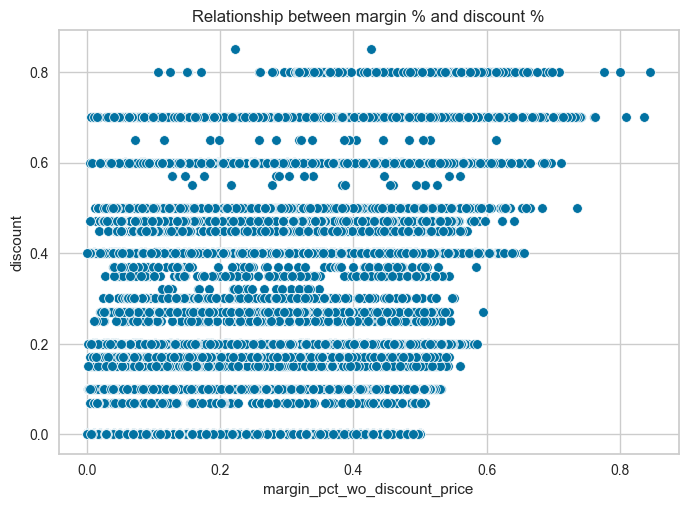

In [218]:
sns.scatterplot(data=global_superstore,
                x="margin_pct_wo_discount_price",
                y="discount")
plt.title("Relationship between margin % and discount %")
plt.show()

As it was obvious, margins are not a limit for discount %, which results in losses where discounts surpass margins. Taking into account discounts are also applied to shipping costs, these margins are reduced even more when discounts are applied.

**Q**: Is there a correlation with ship mode and shipping cost?

Yes. It seems that shipping cost determines the ship_mode, which in turn shipping cost is determined according to the value of the purchase, given its high correlation with sales. 

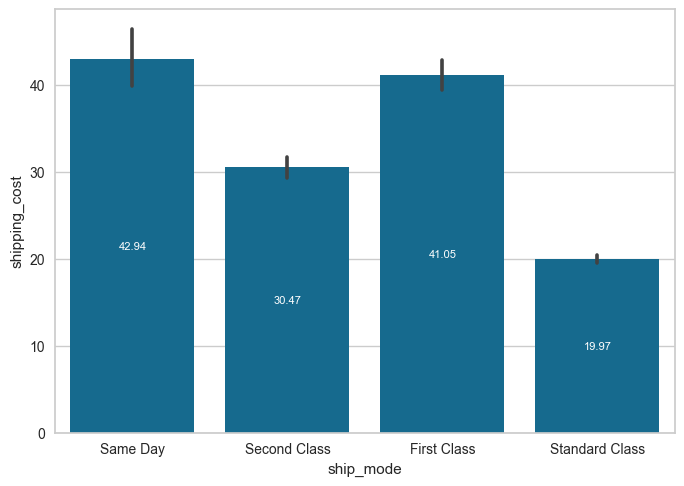

In [107]:
ax = sns.barplot(data=global_superstore,
            x="ship_mode",
            y="shipping_cost",
            estimator="mean")
dvs.plot_bar_labels(ax)

**Q**: What are the most sold products? And what are their revenue and profits?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_21304\2470855372.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(product_sold_units.iloc[:10,:].index,rotation=45)


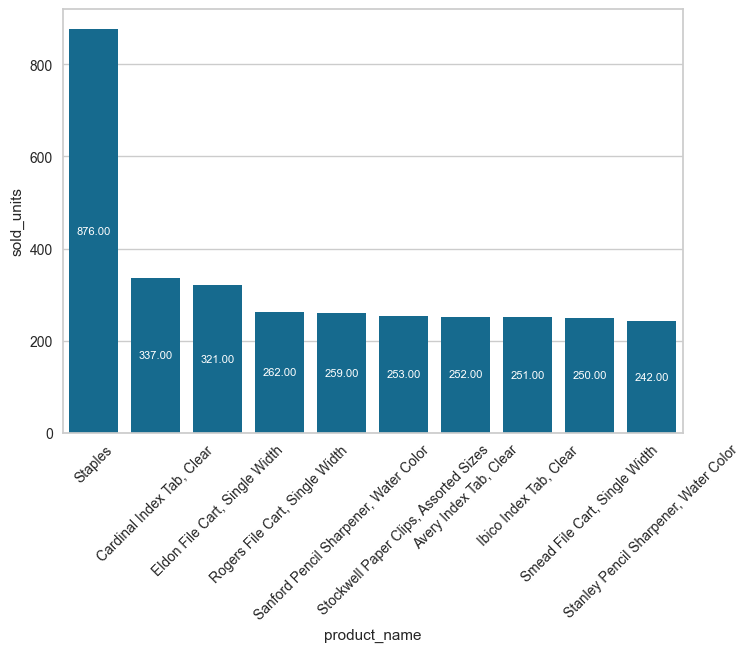

In [108]:
product_sold_units = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="sold_units",ascending=False))

ax= sns.barplot(data=product_sold_units.iloc[:10,:].reset_index(),
            x="product_name",
            y="sold_units")
ax.set_xticklabels(product_sold_units.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

**Q:** What products drive the most revenue?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_21304\2216897617.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(product_revenue.iloc[:10,:].index,rotation=45)


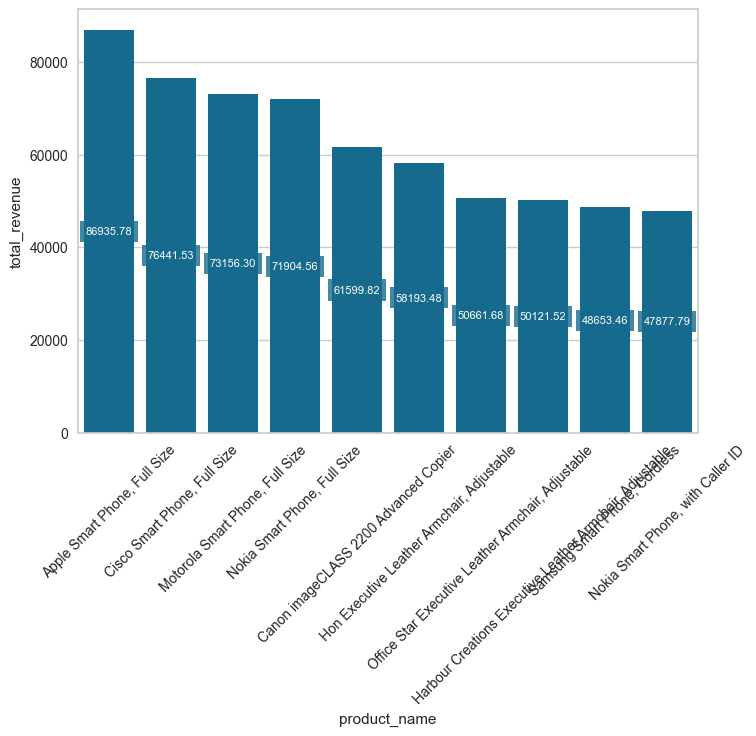

In [109]:
product_revenue = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="total_revenue",ascending=False))

ax= sns.barplot(data=product_revenue.iloc[:10,:].reset_index(),
            x="product_name",
            y="total_revenue")
ax.set_xticklabels(product_revenue.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

**Q**: What are the most profitable?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_21304\157762280.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(products_profit.iloc[:10,:].index,rotation=45)


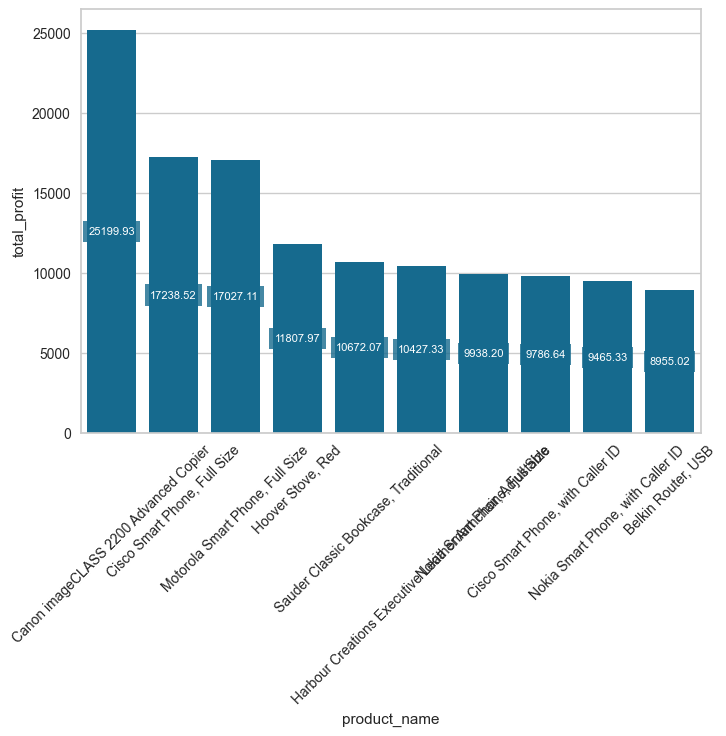

In [110]:
products_profit = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="total_profit",ascending=False))

ax= sns.barplot(data=products_profit.iloc[:10,:].reset_index(),
            x="product_name",
            y="total_profit")
ax.set_xticklabels(products_profit.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

**Q**: What are the most sold categories product categories? In the 3 years of activity

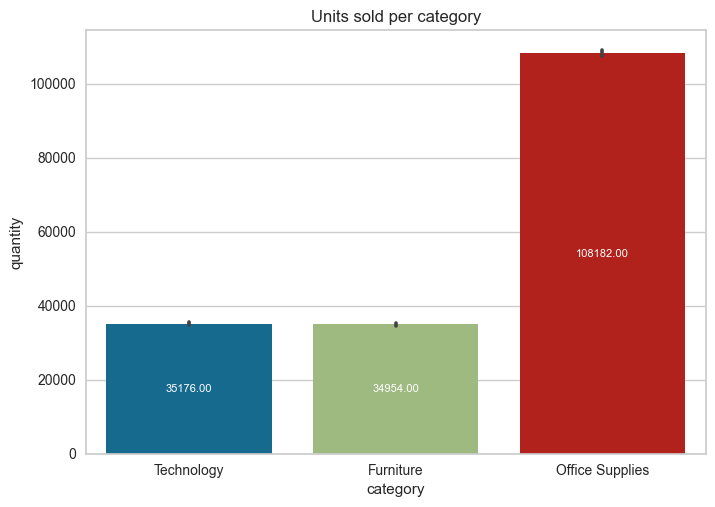

In [111]:
plt.title("Units sold per category")
ax = sns.barplot(data=global_superstore,
            x="category",
            y="quantity",
            estimator="sum",
            hue="category")

dvs.plot_bar_labels(ax)

**Q**: What categories are the biggest revenue drivers?

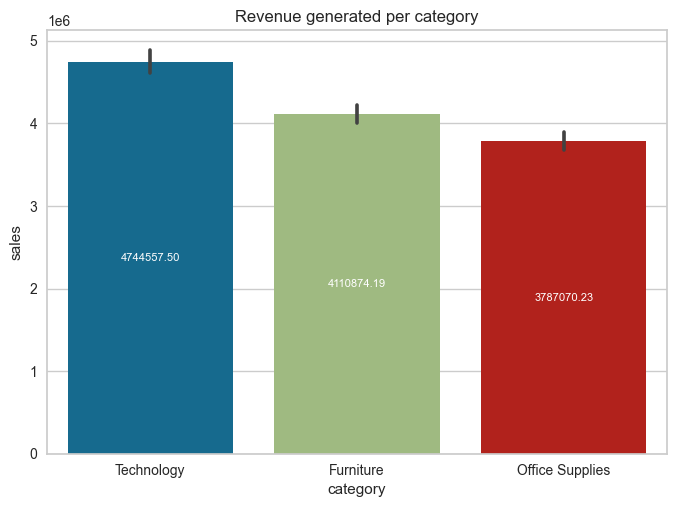

In [112]:
plt.title("Revenue generated per category")
ax= sns.barplot(data=global_superstore,
            x="category",
            y="sales",
            estimator="sum",
            hue="category")
dvs.plot_bar_labels(ax)

**Q:** What are the biggest profit drivers?

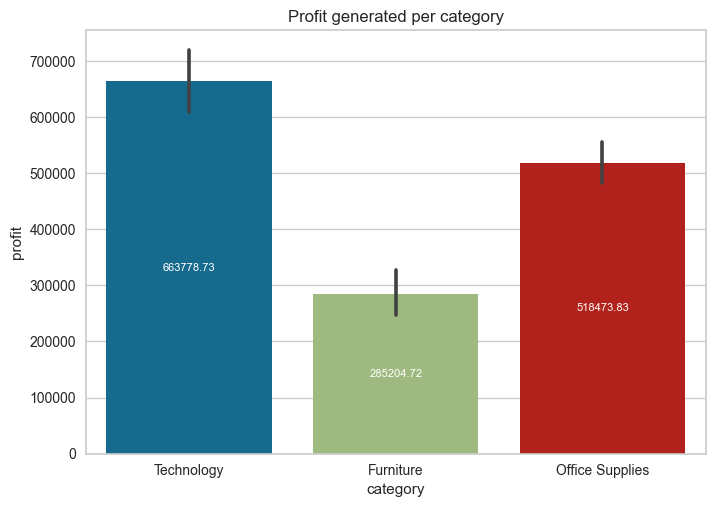

In [113]:
plt.title("Profit generated per category")
ax= sns.barplot(data=global_superstore,
            x="category",
            y="profit",
            estimator="sum",
            hue="category")
dvs.plot_bar_labels(ax)

What are the ones with the biggest margins?

Plot this with a waterfall cash-flow plot or a stacked plot

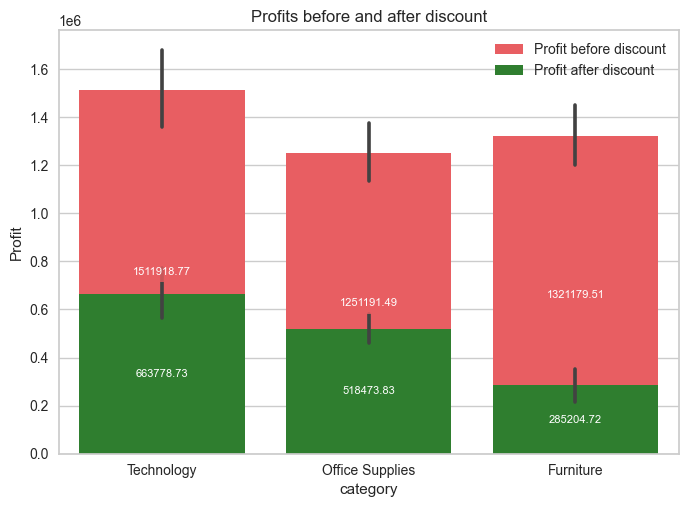

In [114]:
products_profit = (global_superstore.groupby(["product_name","category"]).agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum"),
                                                            margin_wo_discount=("margin_wo_discount","mean"),
                                                            margin=("margin_discount","mean")
                                                            )
                                                        .sort_values(by="total_profit",ascending=False))


ax= sns.barplot(data=products_profit,
            x="category",
            y="total_profit_before_discount",
            estimator="sum",label="Profit before discount", color="#FF474C")

sns.barplot(data=products_profit,
            x="category",
            y="total_profit",
            estimator="sum", ax=ax,label="Profit after discount", color="forestgreen")
dvs.plot_bar_labels(ax)
plt.title("Profits before and after discount")
plt.ylabel("Profit")
plt.show()

**Q**: Most profitable category per unit?

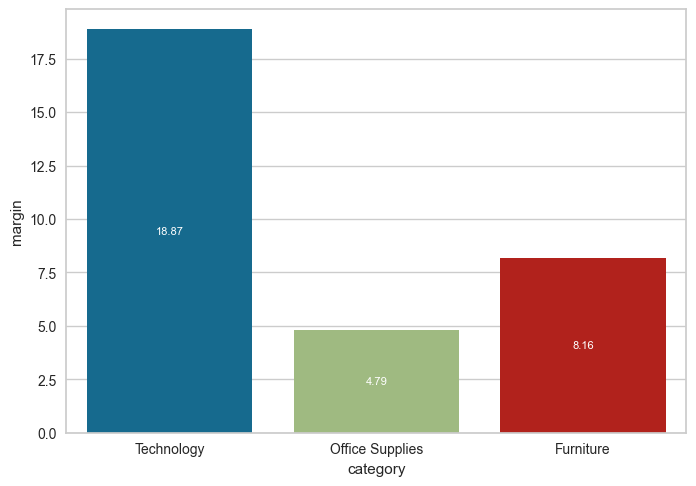

In [115]:
products_profit = (global_superstore.groupby(["category"]).agg(
                                                            sold_units=("quantity","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))


ax= sns.barplot(data=products_profit,
            x="category",
            y="margin",
            estimator="mean",
            hue="category")
dvs.plot_bar_labels(ax)

#### Subcategories

**Q**:What are the most sold subcategories?

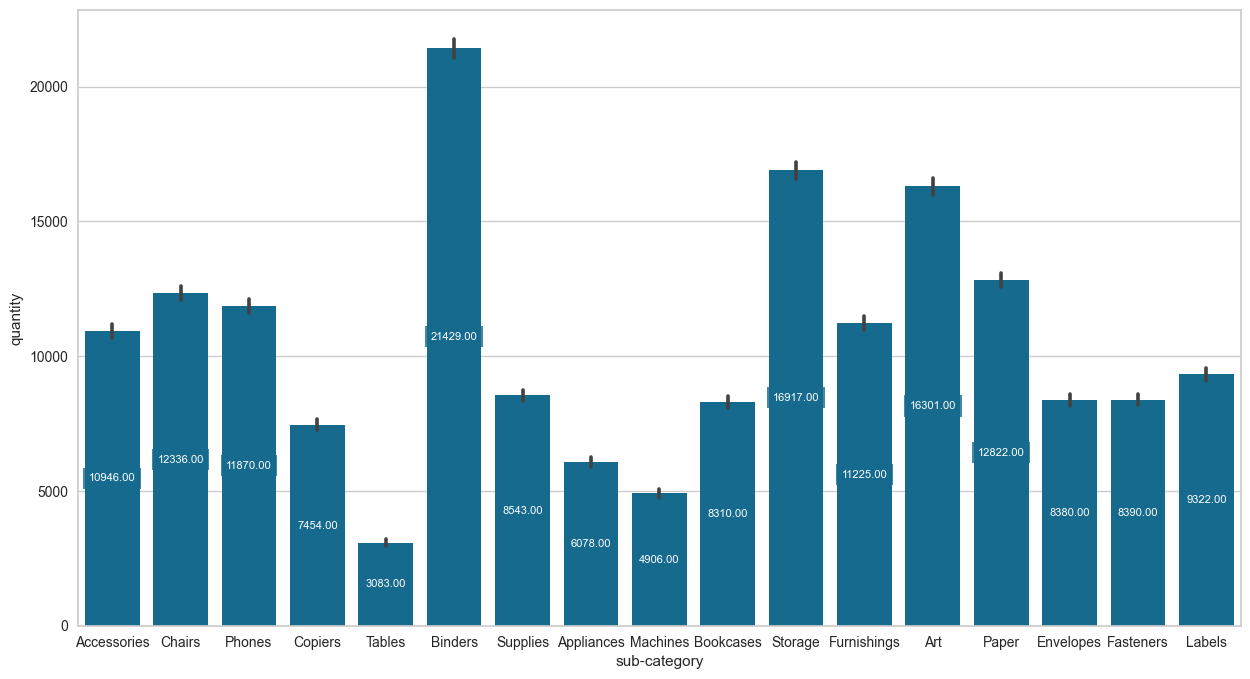

In [116]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="quantity",
            estimator="sum")
dvs.plot_bar_labels(ax)

**Q:** What are the biggest revenue drivers?

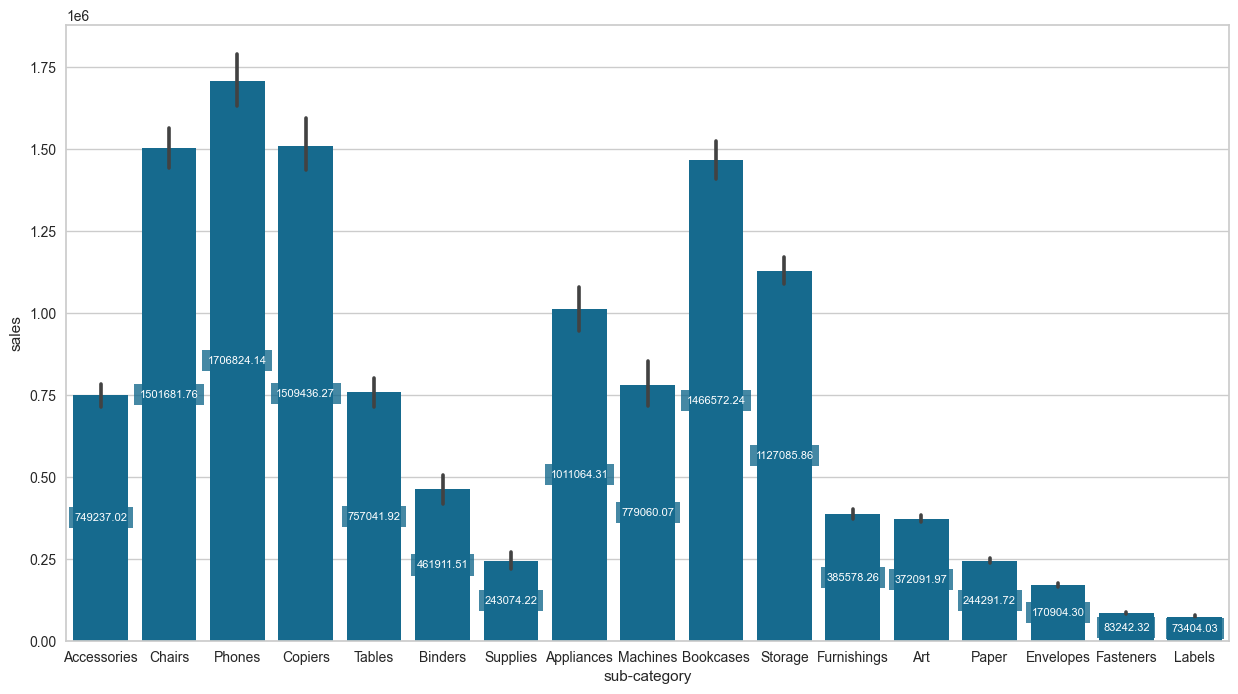

In [117]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="sales",
            estimator="sum")
dvs.plot_bar_labels(ax)

**Q**: What are the biggest profit drivers?

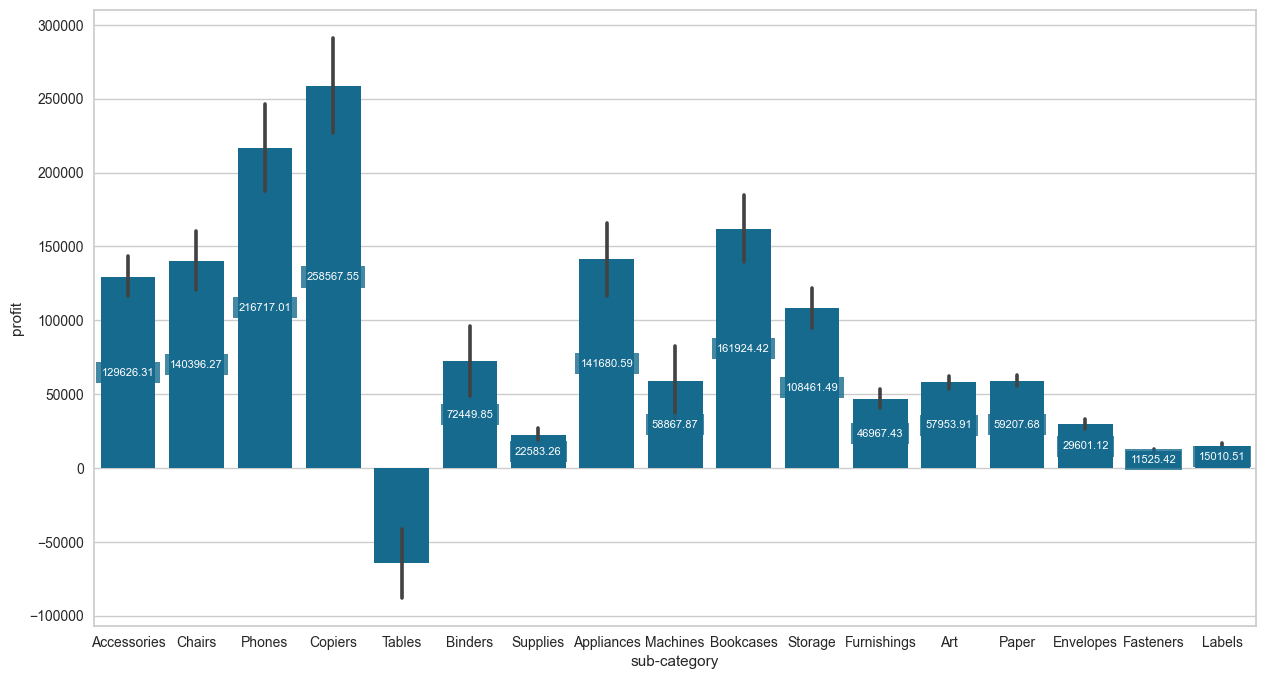

In [118]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

**Q**: What are the margins from each sub-category?

In [119]:
subcategory_profit = (global_superstore.groupby(["sub-category"]).agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"],
                                                                    avg_discount=lambda df: df["total_discount"]/df["total_revenue"])
                                                        .sort_values(by="margin",ascending=False))

Before discounts

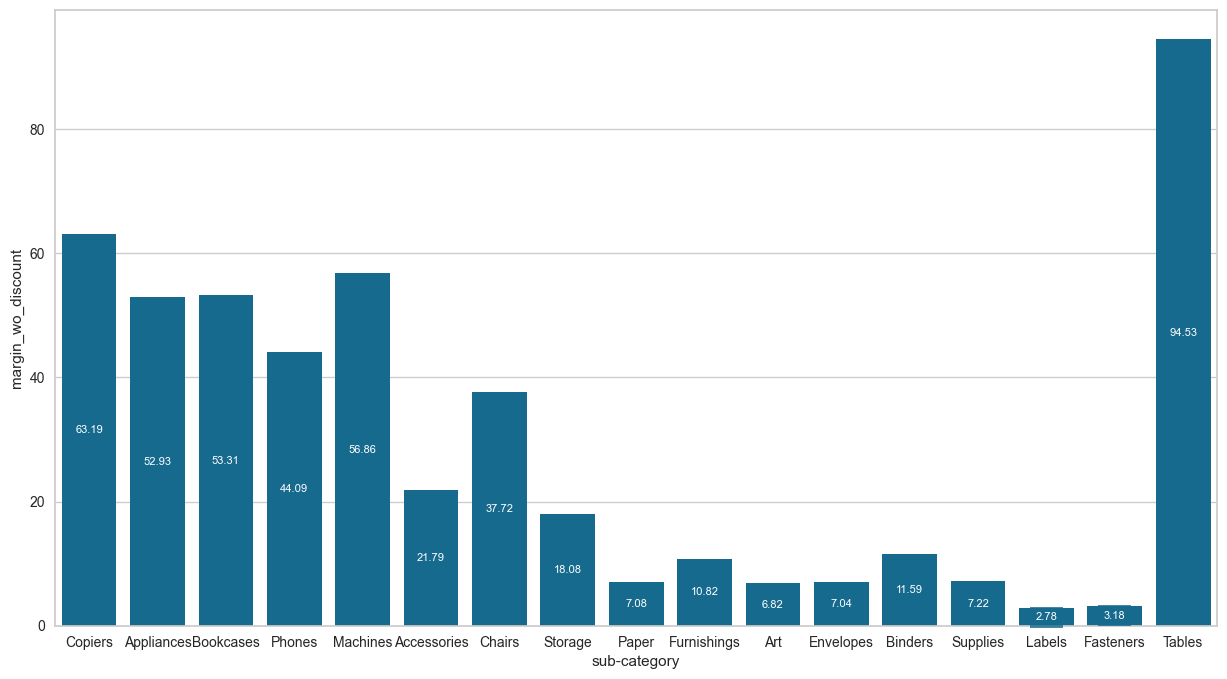

In [120]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="margin_wo_discount",
            estimator="mean")
dvs.plot_bar_labels(ax)

After discounts

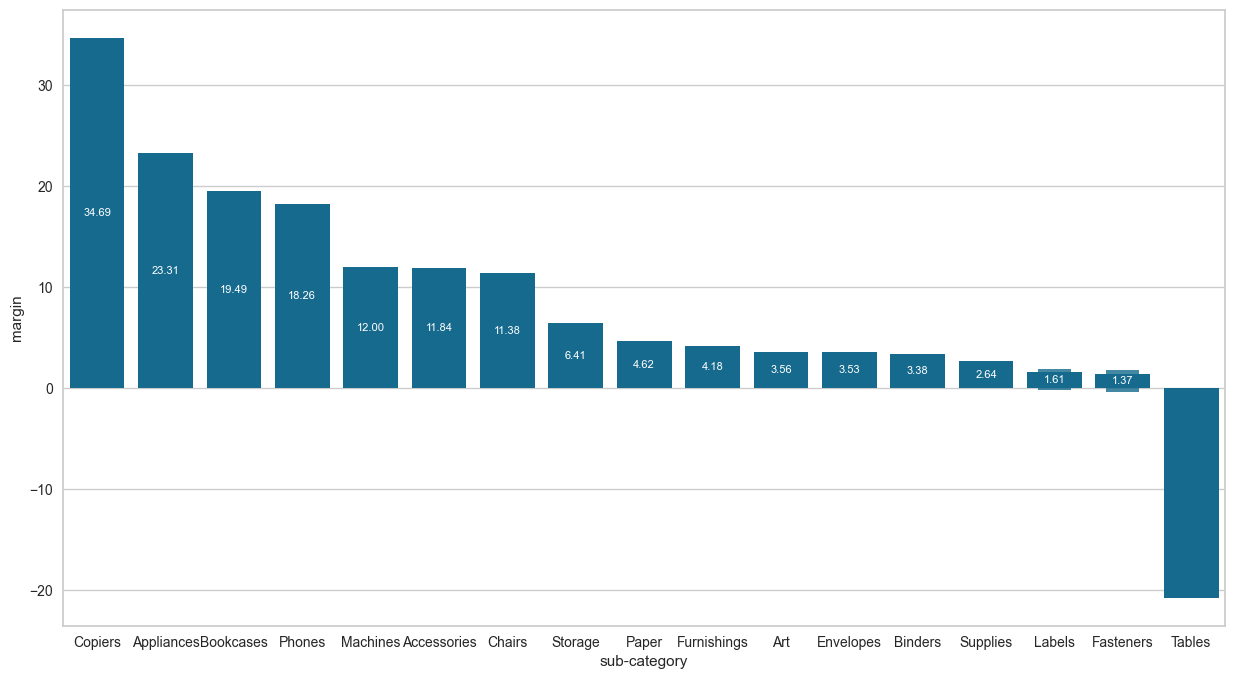

In [121]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="margin",
            estimator="mean",
            order=subcategory_profit.index)
dvs.plot_bar_labels(ax)

Discounts of each sub-category

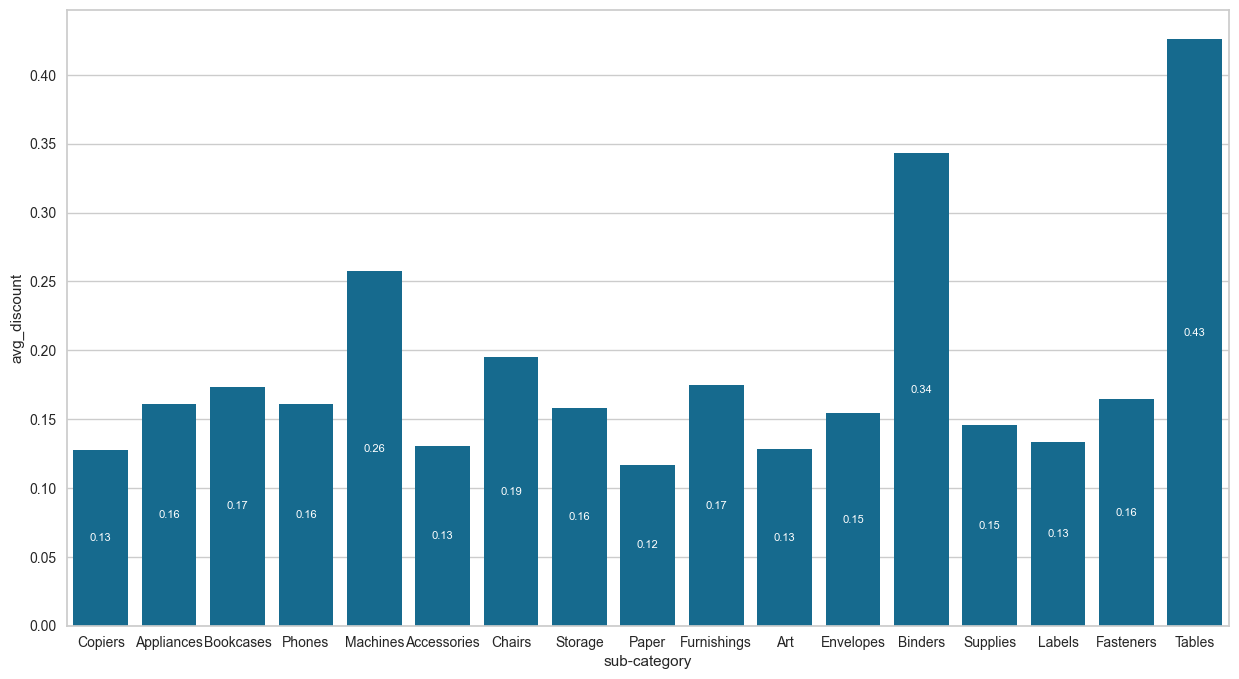

In [122]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="avg_discount",
            estimator="mean",
            order=subcategory_profit.index)
dvs.plot_bar_labels(ax)

### 2.2.2 Order level analysis

Now, to inspect the context around orders it is necessary to aggregate certain metrics at that level.

In [123]:
# Aggregation at order level
order_sales = (global_superstore
                .groupby("order_id")[["sales","profit","quantity","discounted_price","shipping_cost"]]
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum")))

# Creation of profit proportion metric
order_sales["profit_prop"] = order_sales["profit"] / order_sales["sales"] 

# Calculation of discount from aggregated discounted price and sales
order_sales["discount"] = order_sales["discounted_price"] / (order_sales["discounted_price"] + order_sales["sales"])

order_sales.describe().T

count        mean         std          min       25%  \
sales             25035.0  504.993086  807.070936     0.556000  63.50925   
profit            25035.0   58.616229  275.302973 -6892.374800   0.00000   
quantity          25035.0    7.122508    6.156871     1.000000   3.00000   
discounted_price  25035.0   94.427335  327.636917     0.000000   0.00000   
shipping_cost     25035.0   54.037176   95.961036     0.000000   5.71500   
profit_prop       25035.0    0.047601    0.440353    -3.850924   0.00000   
discount          25035.0    0.144203    0.206658     0.000000   0.00000   

                         50%         75%         max  
sales             206.820000  615.575100  23661.2280  
profit             20.070000   89.173700   8762.3891  
quantity            5.000000    9.000000     58.0000  
discounted_price    0.000000   67.080000  23510.1420  
shipping_cost      19.470000   59.635000   2076.6200  
profit_prop         0.167881    0.307823      0.5000  
discount            0.000000    0.200000      0.8500

Let's look for relevant pairwise associations with the help of a correlation (spearman) matrix and a pairplot, which is basically a visual equivalent. 

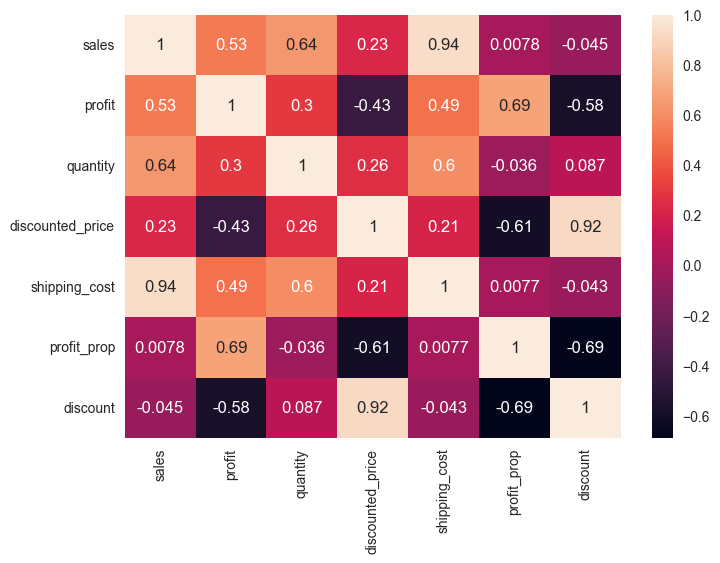

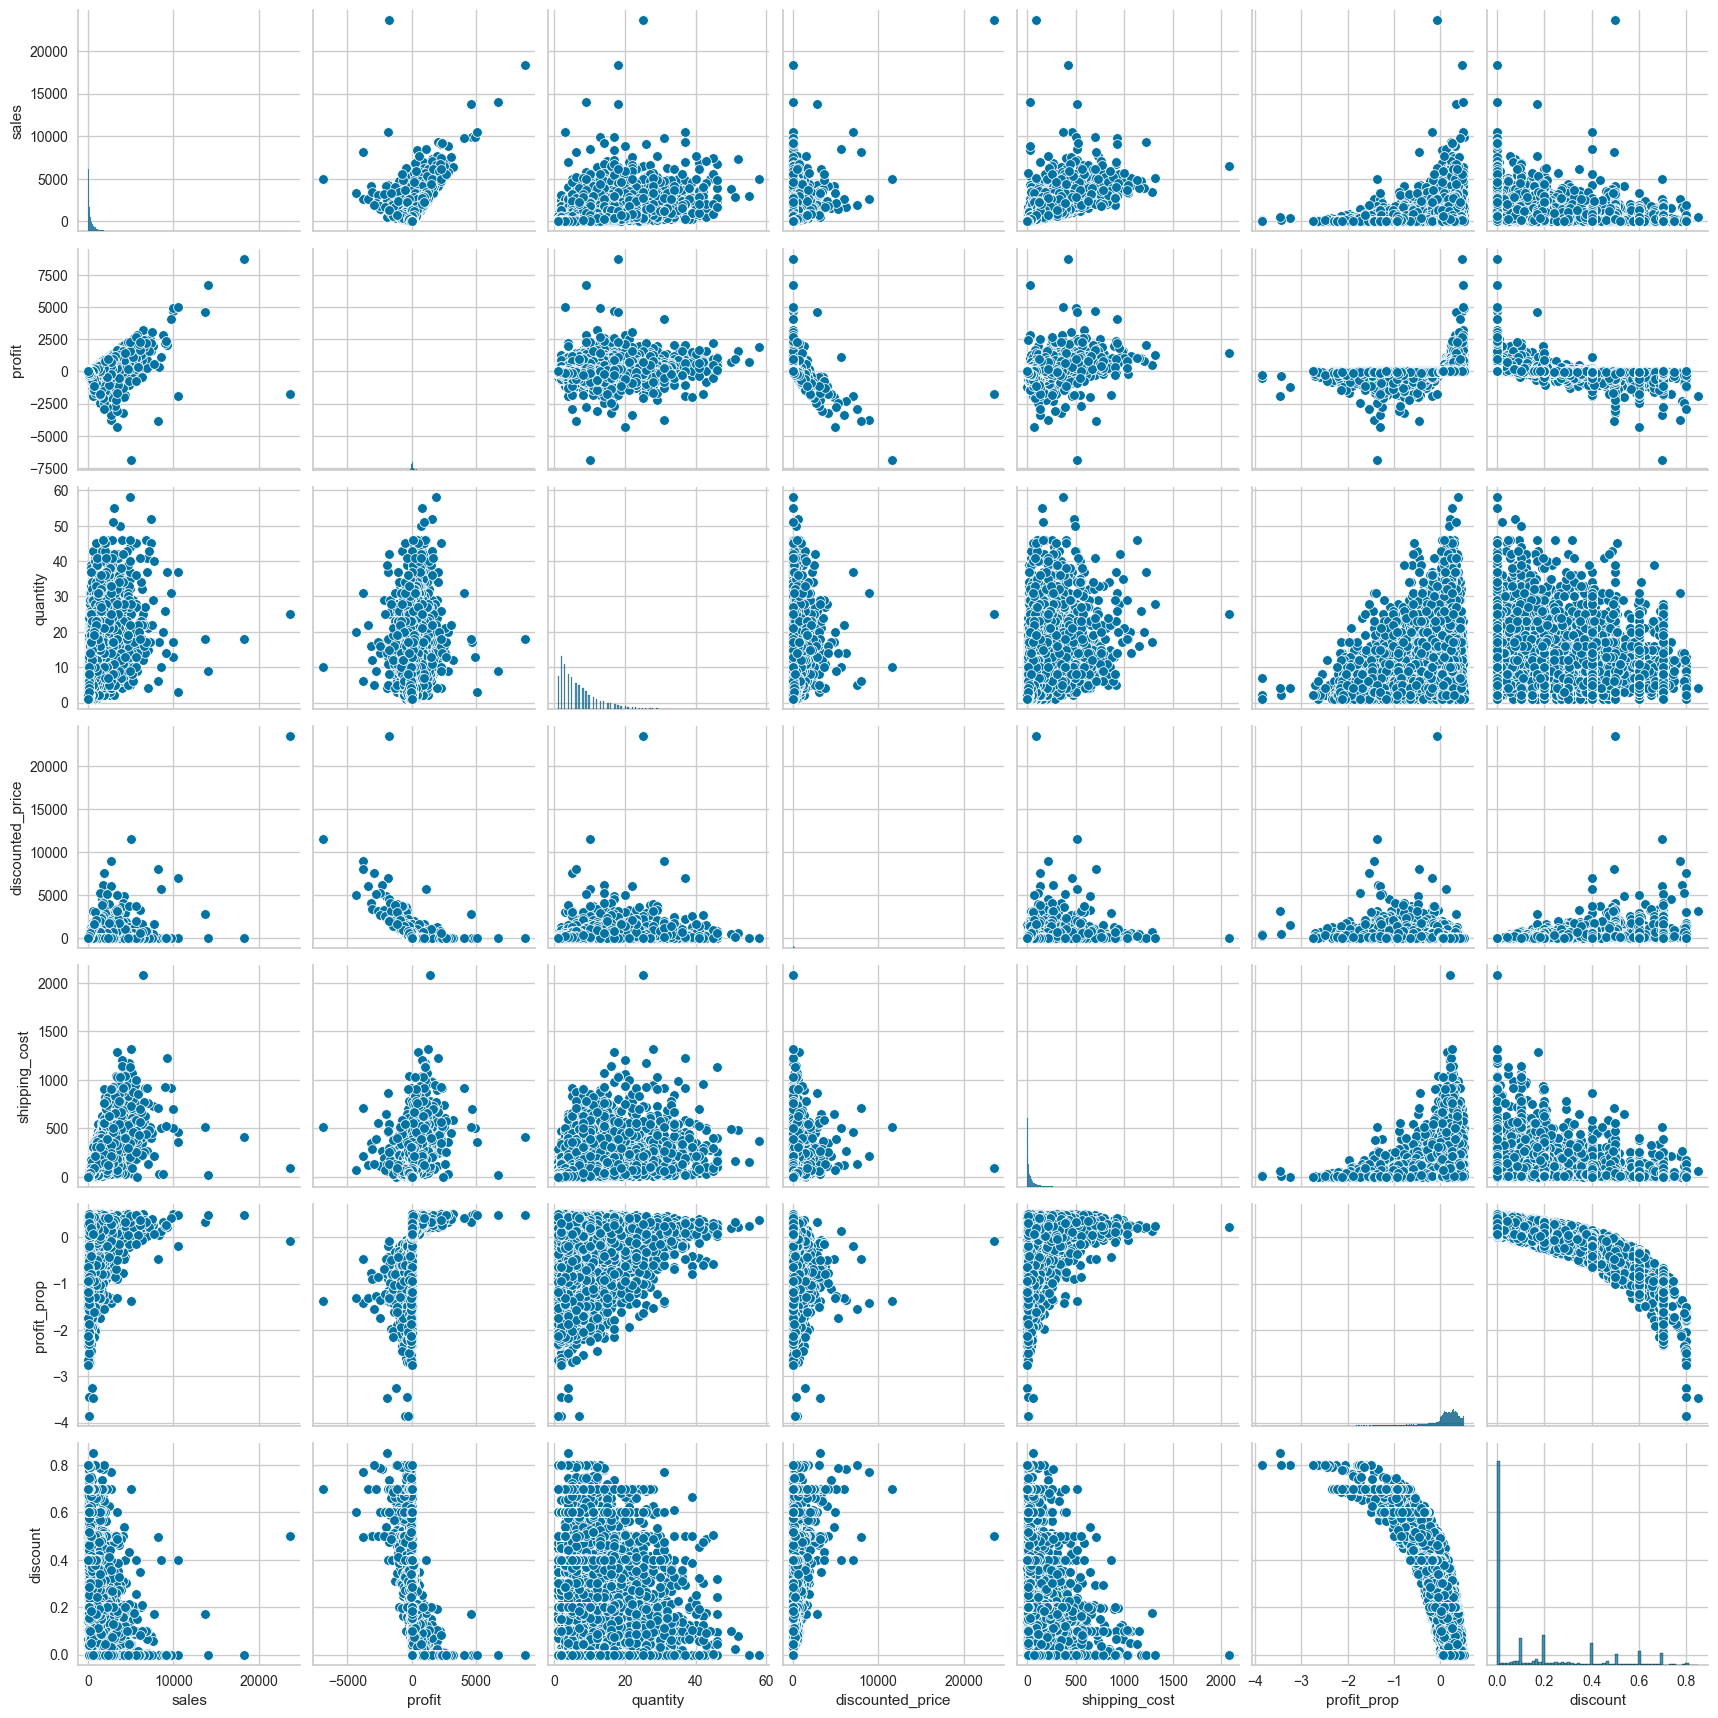

In [124]:
sns.heatmap(order_sales.corr(numeric_only=True,method="spearman"), annot=True)
sns.pairplot(order_sales)

From the plot and matrix above, we see that correlations seen at row level are preserved. Profit is negative and highly correlated with discounts, and shipping costs are positive and highly correlated with sales. Profits are also correlated with shipping costs, probably due to shipping correlation with revenue and its interaction with discounts.

**Q**: What is order priority caused by?

Does order priority bear correlation with the discounts (maybe special offers for clients)? **No**, judging from the barplot below.

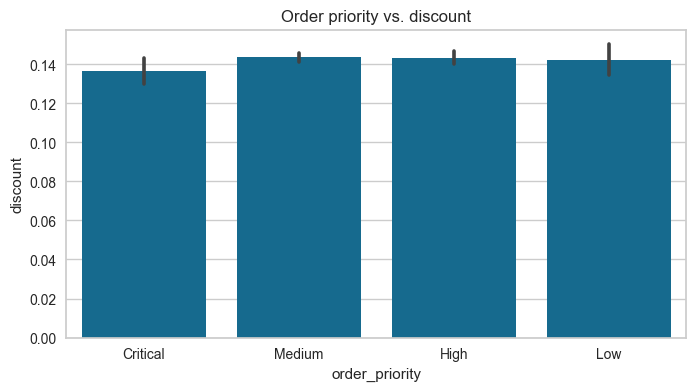

In [125]:
plt.figure(figsize=(8,4))
plt.title("Order priority vs. discount")
sns.barplot(data=global_superstore,
            x="order_priority",
            y="discount",
            estimator="mean")
plt.show()

Does order priority bear correlation with the amount of revenue from that order ('sales')? **No**, judging from the barplot below.

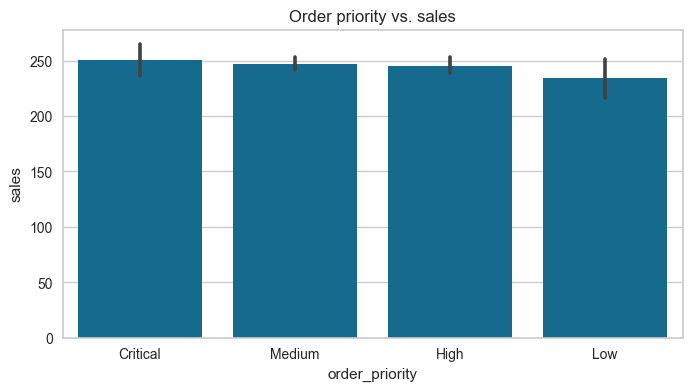

In [126]:
plt.figure(figsize=(8,4))
plt.title("Order priority vs. sales")
sns.barplot(data=global_superstore,
            x="order_priority",
            y="sales",
            estimator="mean")
plt.show()

#### 2.2.2.1 Ship mode and priority

Is there a correlation between shipmode and sales?

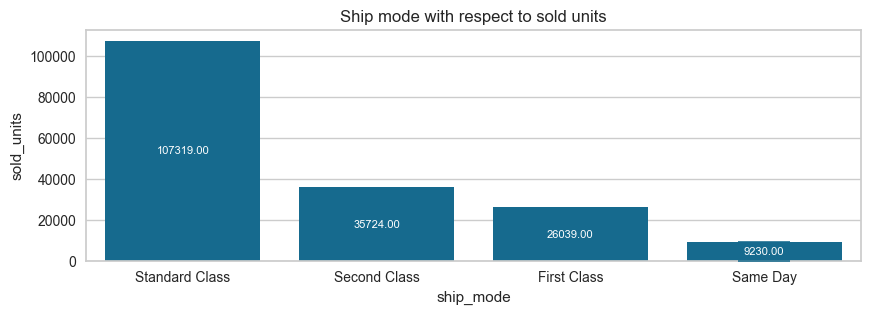

In [168]:
# metric calculation
ship_modes_aggregation = (global_superstore.groupby(["ship_mode"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))

# plotting the metrics
plt.figure(figsize=(10,3))
plt.title("Ship mode with respect to sold units")
ax= sns.barplot(data=ship_modes_aggregation,
            x="ship_mode",
            y="sold_units",
            estimator="sum")
dvs.plot_bar_labels(ax)

Ship mode with respect to total revenue

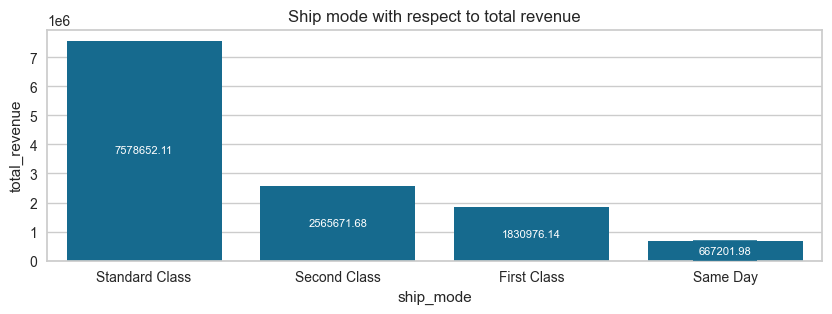

In [169]:
plt.figure(figsize=(10,3))
plt.title("Ship mode with respect to total revenue")
ax= sns.barplot(data=ship_modes_aggregation,
            x="ship_mode",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

#### 2.2.2.2 Order priority

Is there a correlation between order priority and sales?

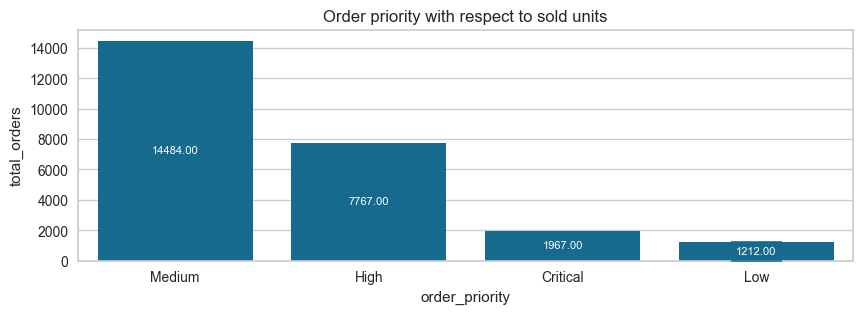

In [170]:
order_priority_aggregation = (global_superstore.groupby(["order_priority"])[["order_id","quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                                total_orders=("order_id","nunique"),
                                                                sold_units=("quantity","sum"),
                                                                total_revenue=("sales","sum"),
                                                                avg_revenue=("sales","mean"),
                                                                total_profit=("profit","sum"),
                                                                total_discount=("discounted_price","sum"),
                                                                total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["total_orders"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["total_orders"],
                                                                    avg_revenue=lambda df: df["total_revenue"]/df["total_orders"])
                                                        .sort_values(by="total_profit",ascending=False))

plt.figure(figsize=(10,3))
plt.title("Order priority with respect to sold units")
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="total_orders",
            estimator="sum")
dvs.plot_bar_labels(ax)

Order priority with respect to revenue

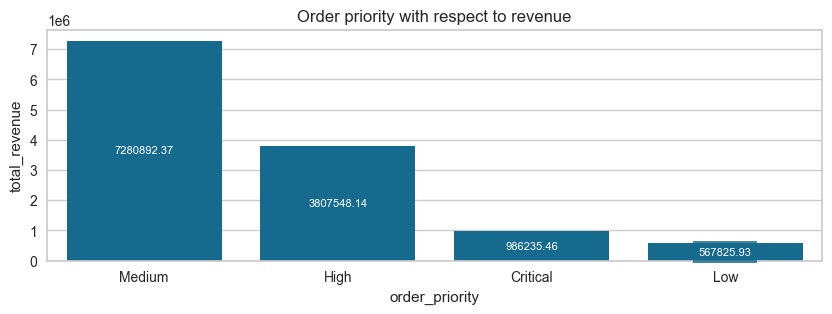

In [171]:
plt.figure(figsize=(10,3))
plt.title("Order priority with respect to revenue")
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

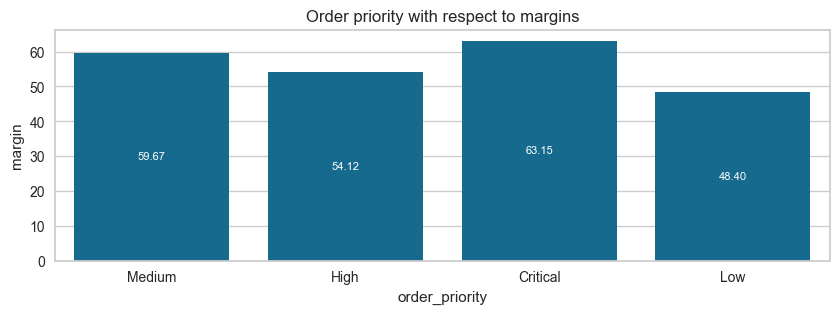

In [172]:
plt.figure(figsize=(10,3))
plt.title("Order priority with respect to margins")
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="margin",
            estimator="sum")
dvs.plot_bar_labels(ax)

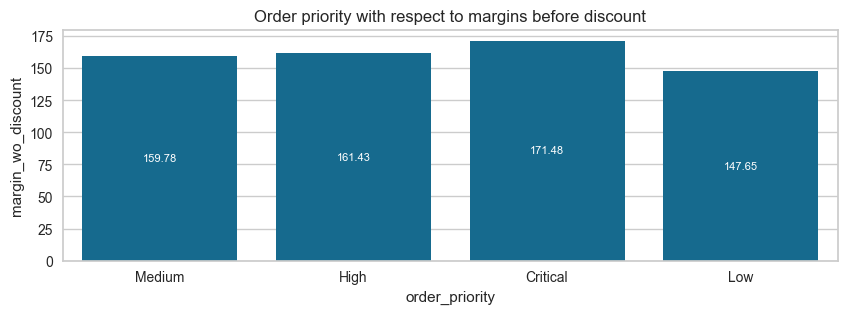

In [173]:
plt.figure(figsize=(10,3))
plt.title("Order priority with respect to margins before discount")
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="margin_wo_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

Order priority is neither correlated with margins nor with avg revenue per order. Therefore, if it is not correlated with customers that bring in a lot of revenue or we are unable to find that relationship, then it should not be included in the model.

### 2.2.3 Product level analysis

Calculate product level aggregations:

In [ ]:
# direct aggregations
product_sales = (global_superstore
                .groupby("product_id")
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum"),
                    original_ppu=("original_ppu","mean")))

# calculate additional columns 
product_sales["profit_prop"] = product_sales["profit"] / product_sales["sales"] 
product_sales["discount"] = product_sales["discounted_price"] / (product_sales["discounted_price"] + product_sales["sales"])
product_sales["discounted_shipping"] = product_sales["shipping_cost"]/(1-product_sales["discount"]) - product_sales["shipping_cost"]
product_sales["profit_before_discounts"] = (product_sales["discounted_shipping"] + 
                                                product_sales["discounted_price"] + product_sales["profit"])

# margin per unit before discount
product_sales["margin_pu_wo_discount"] = product_sales["profit_before_discounts"] / product_sales["quantity"]

# margin per unit after discount
product_sales["margin__pu_discount"] = product_sales["profit"] / product_sales["quantity"]

# margin % before discount
product_sales["margin_pct_wo_discount_price"] = product_sales["margin_pu_wo_discount"] / product_sales["original_ppu"]

product_sales.describe().T

count         mean          std          min  \
sales                         3788.0  3337.513704  5915.960825     1.624000   
profit                        3788.0   387.396328  1176.634700 -8879.970400   
quantity                      3788.0    47.072862    40.672009     1.000000   
discounted_price              3788.0   624.072946  1314.631075     0.000000   
shipping_cost                 3788.0   357.133234   633.519705     0.020000   
original_ppu                  3788.0   101.853152   219.444235     0.990000   
profit_prop                   3788.0     0.151388     0.209014    -2.750000   
discount                      3788.0     0.148859     0.111738     0.000000   
discounted_shipping           3788.0    65.744835   130.042761     0.000000   
profit_before_discounts       3788.0  1077.214109  2086.515062     0.000000   
margin_pu_wo_discount         3788.0    29.718723    86.208291     0.000000   
margin__pu_discount           3788.0     8.005321    45.707969  -986.663378   
margin_pct_wo_discount_price  3788.0     0.307868     0.127017     0.000000   

                                     25%          50%          75%  \
sales                         314.102250  1268.809000  3884.990250   
profit                         14.989350    97.048000   419.569050   
quantity                       18.000000    35.000000    67.000000   
discounted_price               37.056000   186.356250   659.957400   
shipping_cost                  33.157500   134.800000   405.635000   
original_ppu                   11.987927    37.750000   120.082500   
profit_prop                     0.046124     0.164706     0.277648   
discount                        0.080000     0.127273     0.187691   
discounted_shipping             3.914129    19.888236    69.782109   
profit_before_discounts       103.018576   375.941112  1165.635790   
margin_pu_wo_discount           3.310378     9.522070    28.333172   
margin__pu_discount             0.712672     2.915268     9.741276   
margin_pct_wo_discount_price    0.221006     0.298133     0.406996   

                                       max  
sales                         86935.778600  
profit                        25199.928000  
quantity                        876.000000  
discounted_price              22638.480000  
shipping_cost                  8817.340000  
original_ppu                   7546.160000  
profit_prop                       0.500000  
discount                          0.800000  
discounted_shipping            1400.606718  
profit_before_discounts       33773.947636  
margin_pu_wo_discount          3475.281933  
margin__pu_discount            1259.996400  
margin_pct_wo_discount_price      0.665737

From the `describe()`, we see that margin_pct_wo_discount_price ranges from 0% to 66%. This means that this percentage should not be surpassed by discount %, where shipping costs should also be included as they take away amounts not only from the 'sales' amount, effectively making this range shorter.

Let's inspect for some other interesting feature relationships:

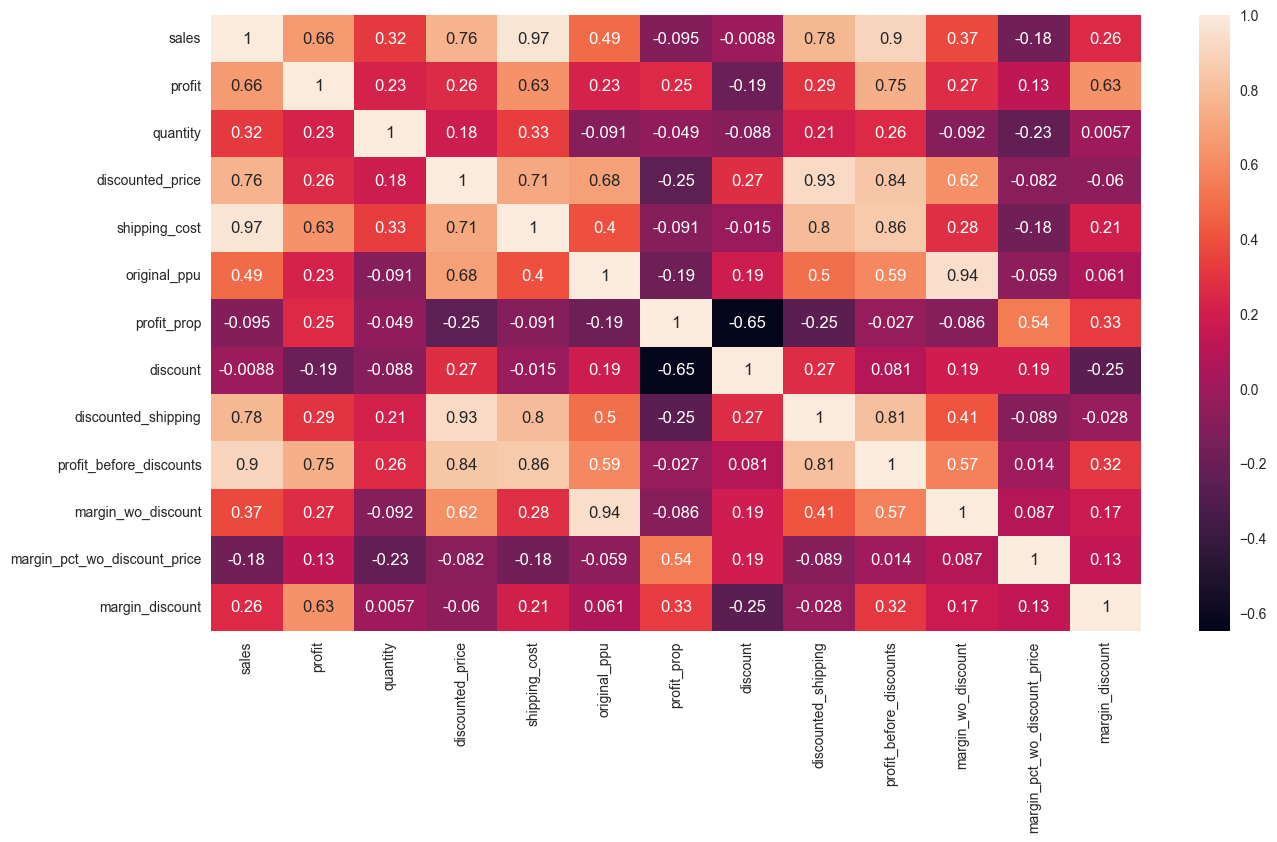

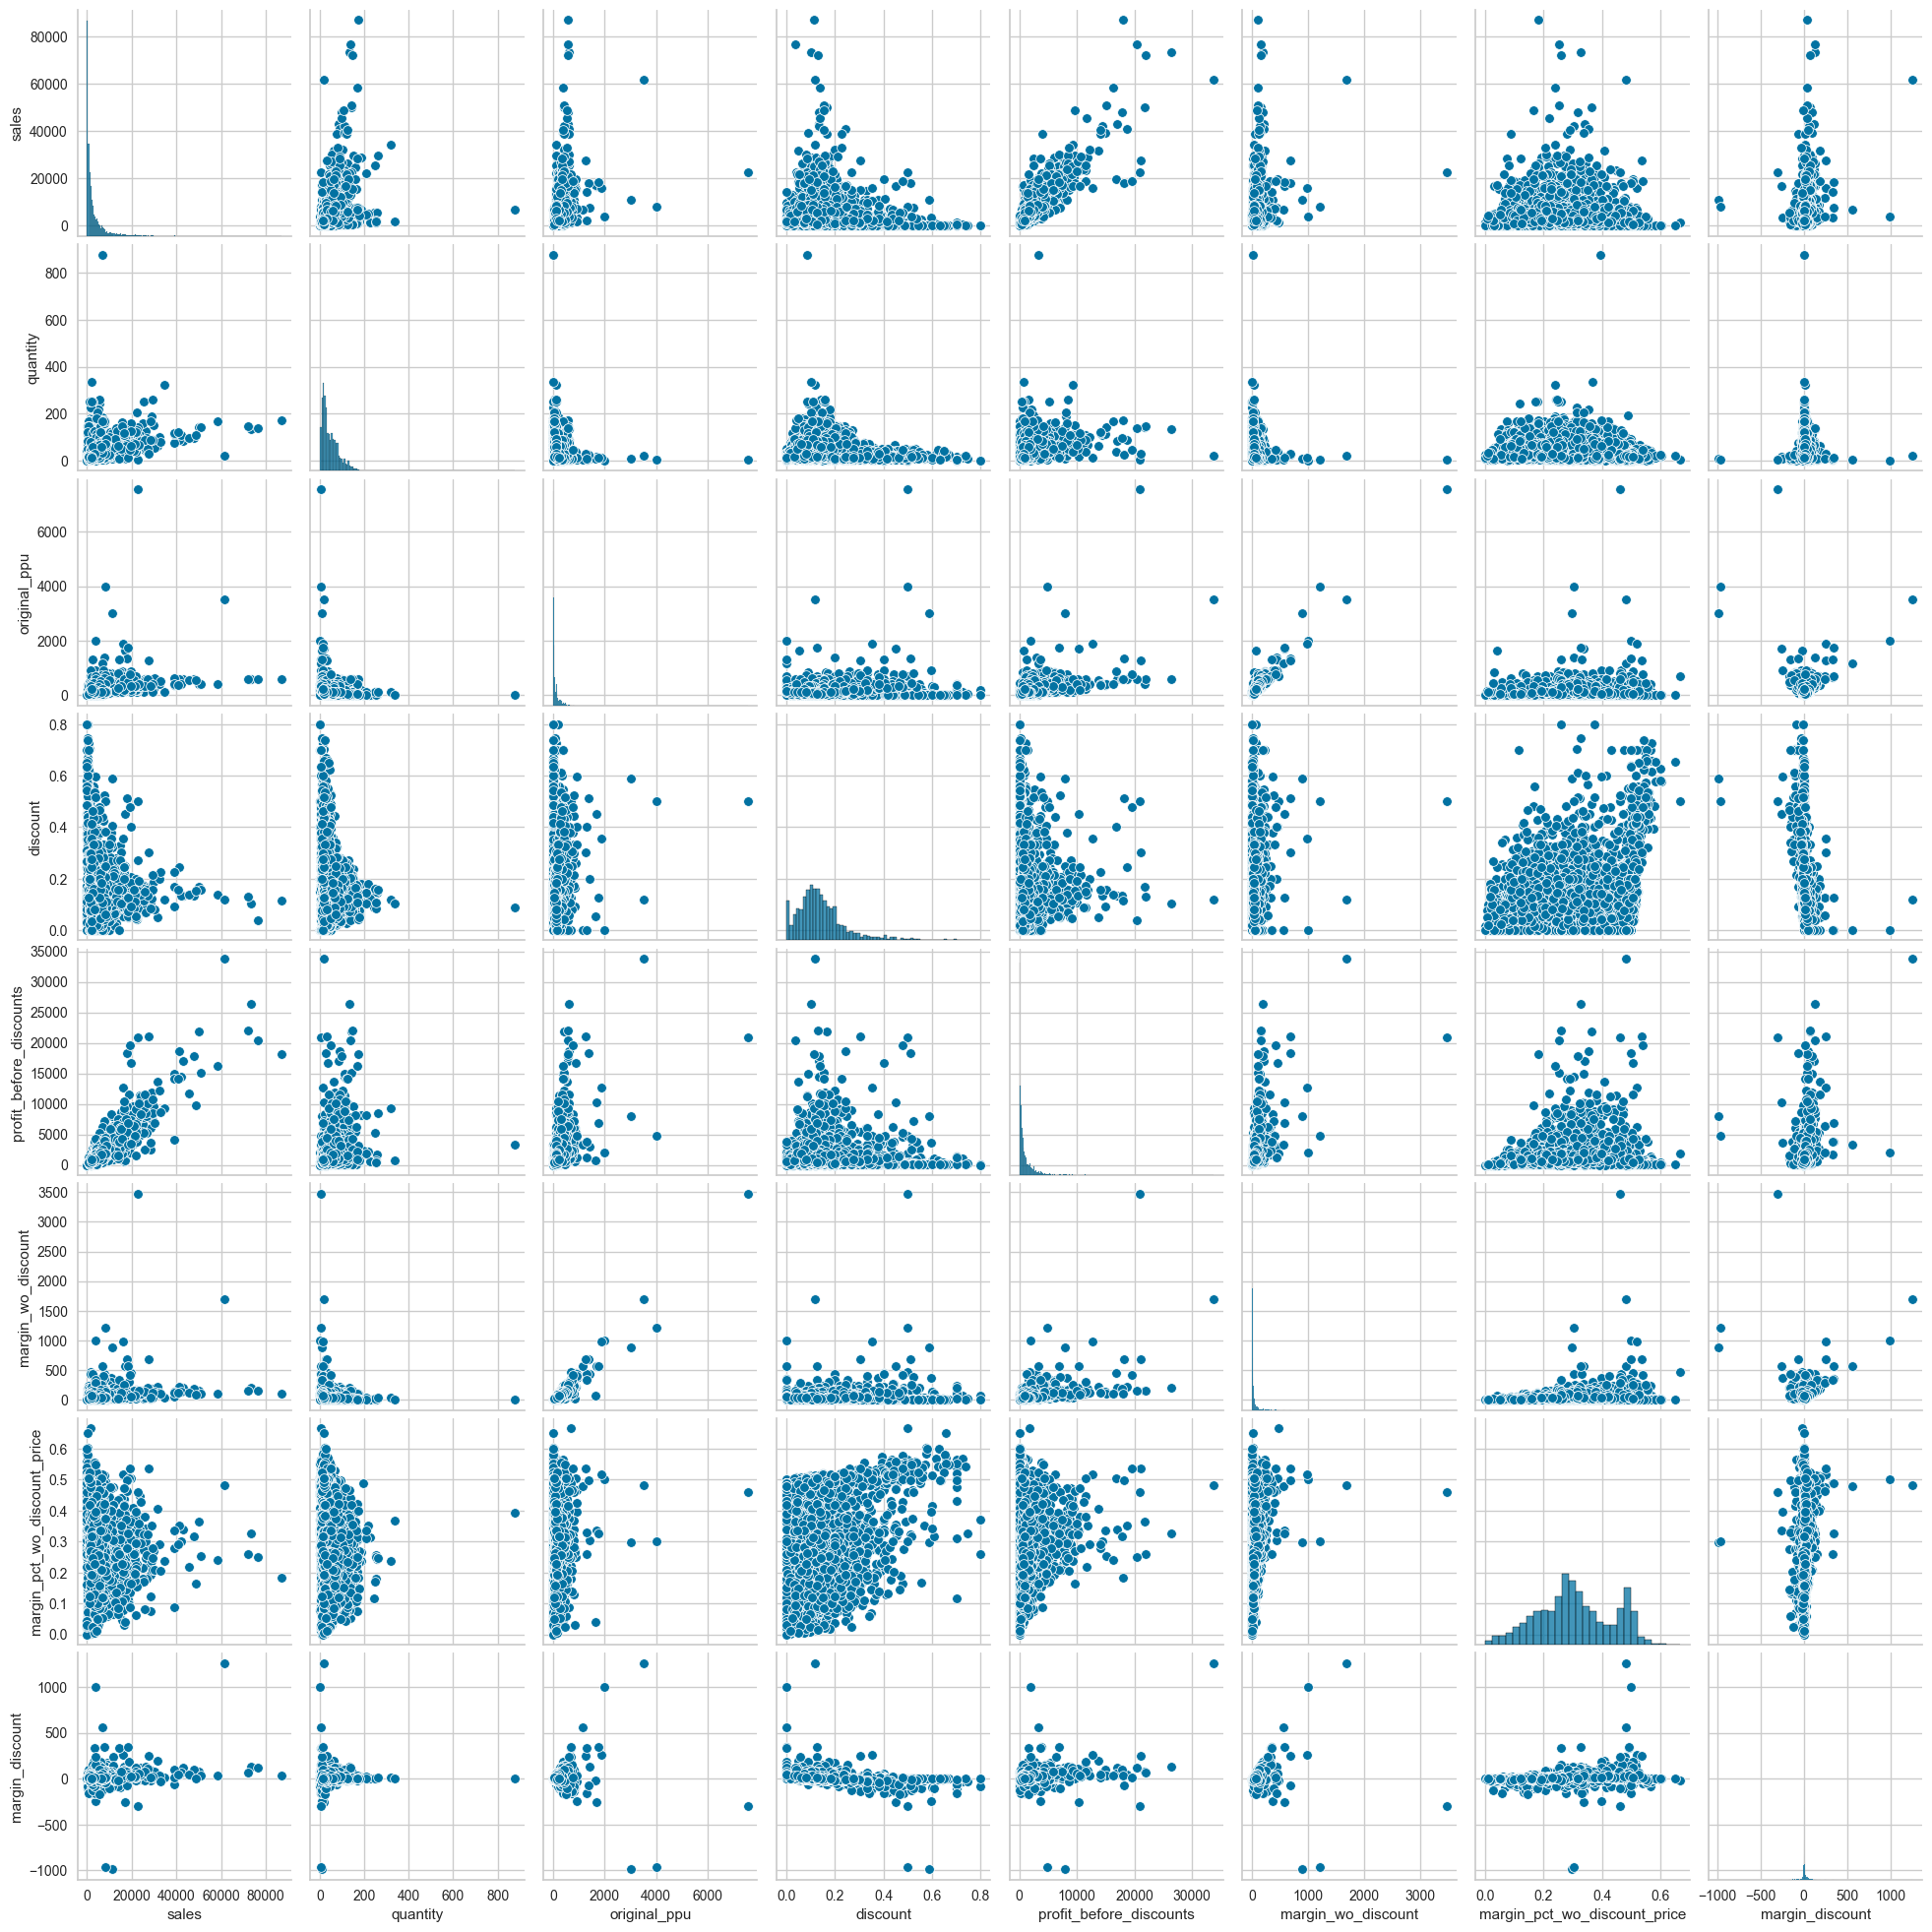

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(product_sales.corr(numeric_only=True), annot=True)
plt.show()
sns.pairplot(product_sales.drop(columns=["shipping_cost","profit_prop","discounted_price","profit","discounted_shipping"]))

From above, we see that margins per unit before discount (margin_pu_wo_discount), original price per unit (original_ppu), sales or worse, margin % per unit before discount, are not correlated with discount %. This means that if total order revenue is not correlated to discounts, and price per unit or margins before discounts either, then discounts are either given to avoid further losses to excess inventory or there are disfunctional discount policies in progress. Zooming into these 2 correlations:

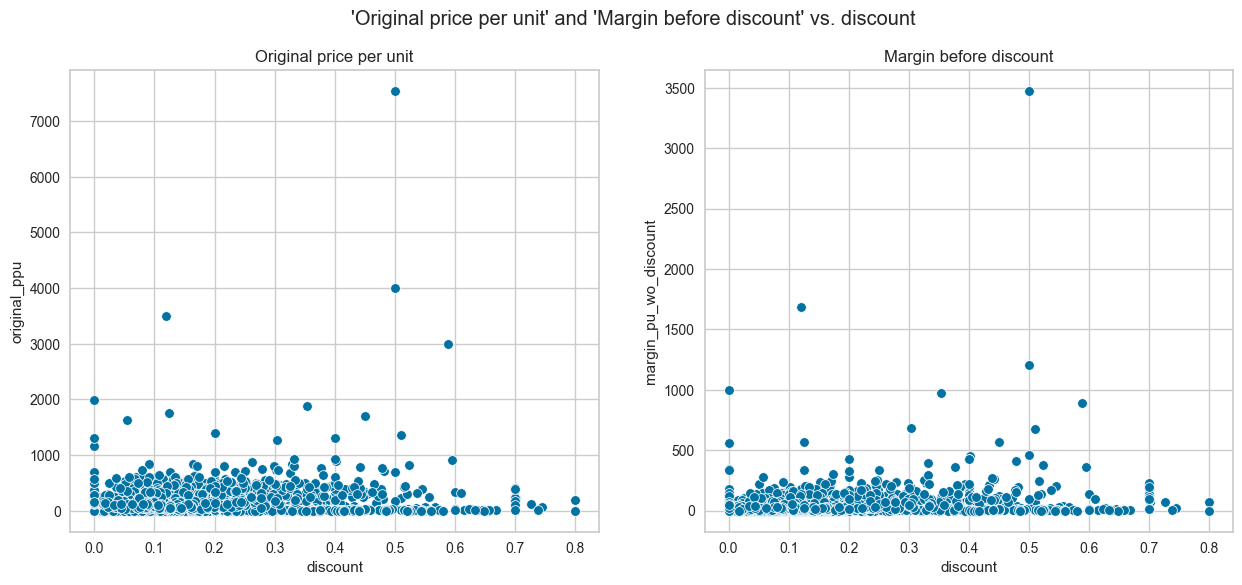

In [204]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("'Original price per unit' and 'Margin before discount' vs. discount")
sns.scatterplot(data=product_sales,
                x="discount",
                y="original_ppu",
                ax=axes[0])
axes[0].set_title("Original price per unit")

sns.scatterplot(data=product_sales,
                x="discount",
                y="margin_pu_wo_discount",
                ax=axes[1])
axes[1].set_title("Margin before discount")
plt.show()

Below, we see that the percentage of margin and percentage of discount are only midly correlated, as they were on the row level. Which cancels the hypothesis that discounts are calculated on product level.

Text(0.5, 1.0, 'Margin % before discount')

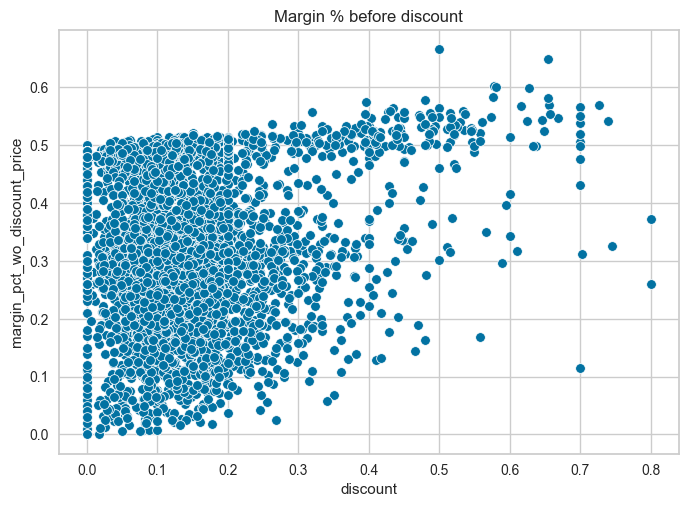

In [208]:
sns.scatterplot(data=product_sales,
                x="discount",
                y="margin_pct_wo_discount_price")
plt.title("Margin % before discount")

### 2.2.5 Customer level

Calculate customer level aggregations:

In [149]:
customer_sales = (global_superstore
                .groupby("customer_id")[["sales","profit","quantity","discounted_price","shipping_cost"]]
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum")))

customer_sales["profit_prop"] = customer_sales["profit"] / customer_sales["sales"] 
customer_sales["discount"] = customer_sales["discounted_price"] / (customer_sales["discounted_price"] + customer_sales["sales"])

customer_sales.describe().T

count          mean          std          min           25%  \
sales             795.0  15902.518126  5209.813042  3892.227000  12242.608650   
profit            795.0   1845.858228  1544.335187 -6151.558100    984.341310   
quantity          795.0    224.291824    50.569979    79.000000    188.000000   
discounted_price  795.0   2973.570214  1901.298266   246.543000   1781.426330   
shipping_cost     795.0   1701.661245   594.756602   406.040000   1270.655000   
profit_prop       795.0      0.112522     0.084185    -0.458055      0.074263   
discount          795.0      0.154155     0.065723     0.033665      0.109192   

                           50%           75%           max  
sales             15257.533900  18770.796450  40488.070800  
profit             1788.719800   2603.600930   8672.898900  
quantity            222.000000    256.000000    411.000000  
discounted_price   2603.340800   3713.811750  24878.727040  
shipping_cost      1641.800000   2034.210000   4127.570000  
profit_prop           0.119835      0.167039      0.367335  
discount              0.145182      0.184874      0.492058

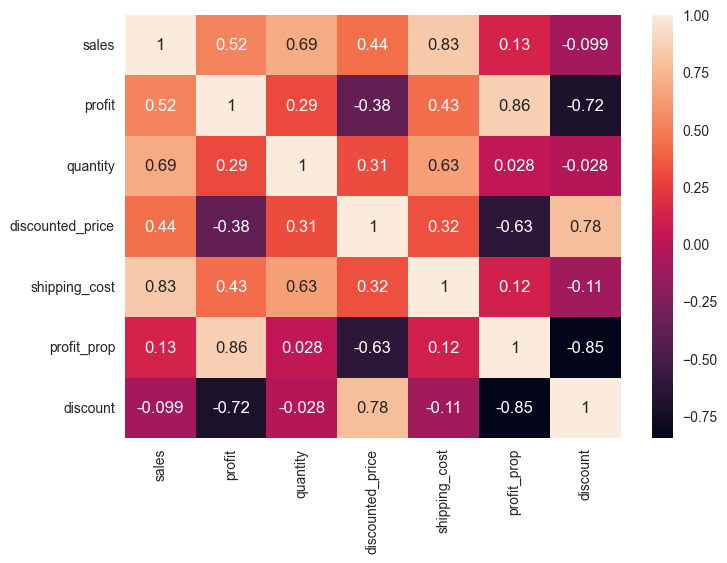

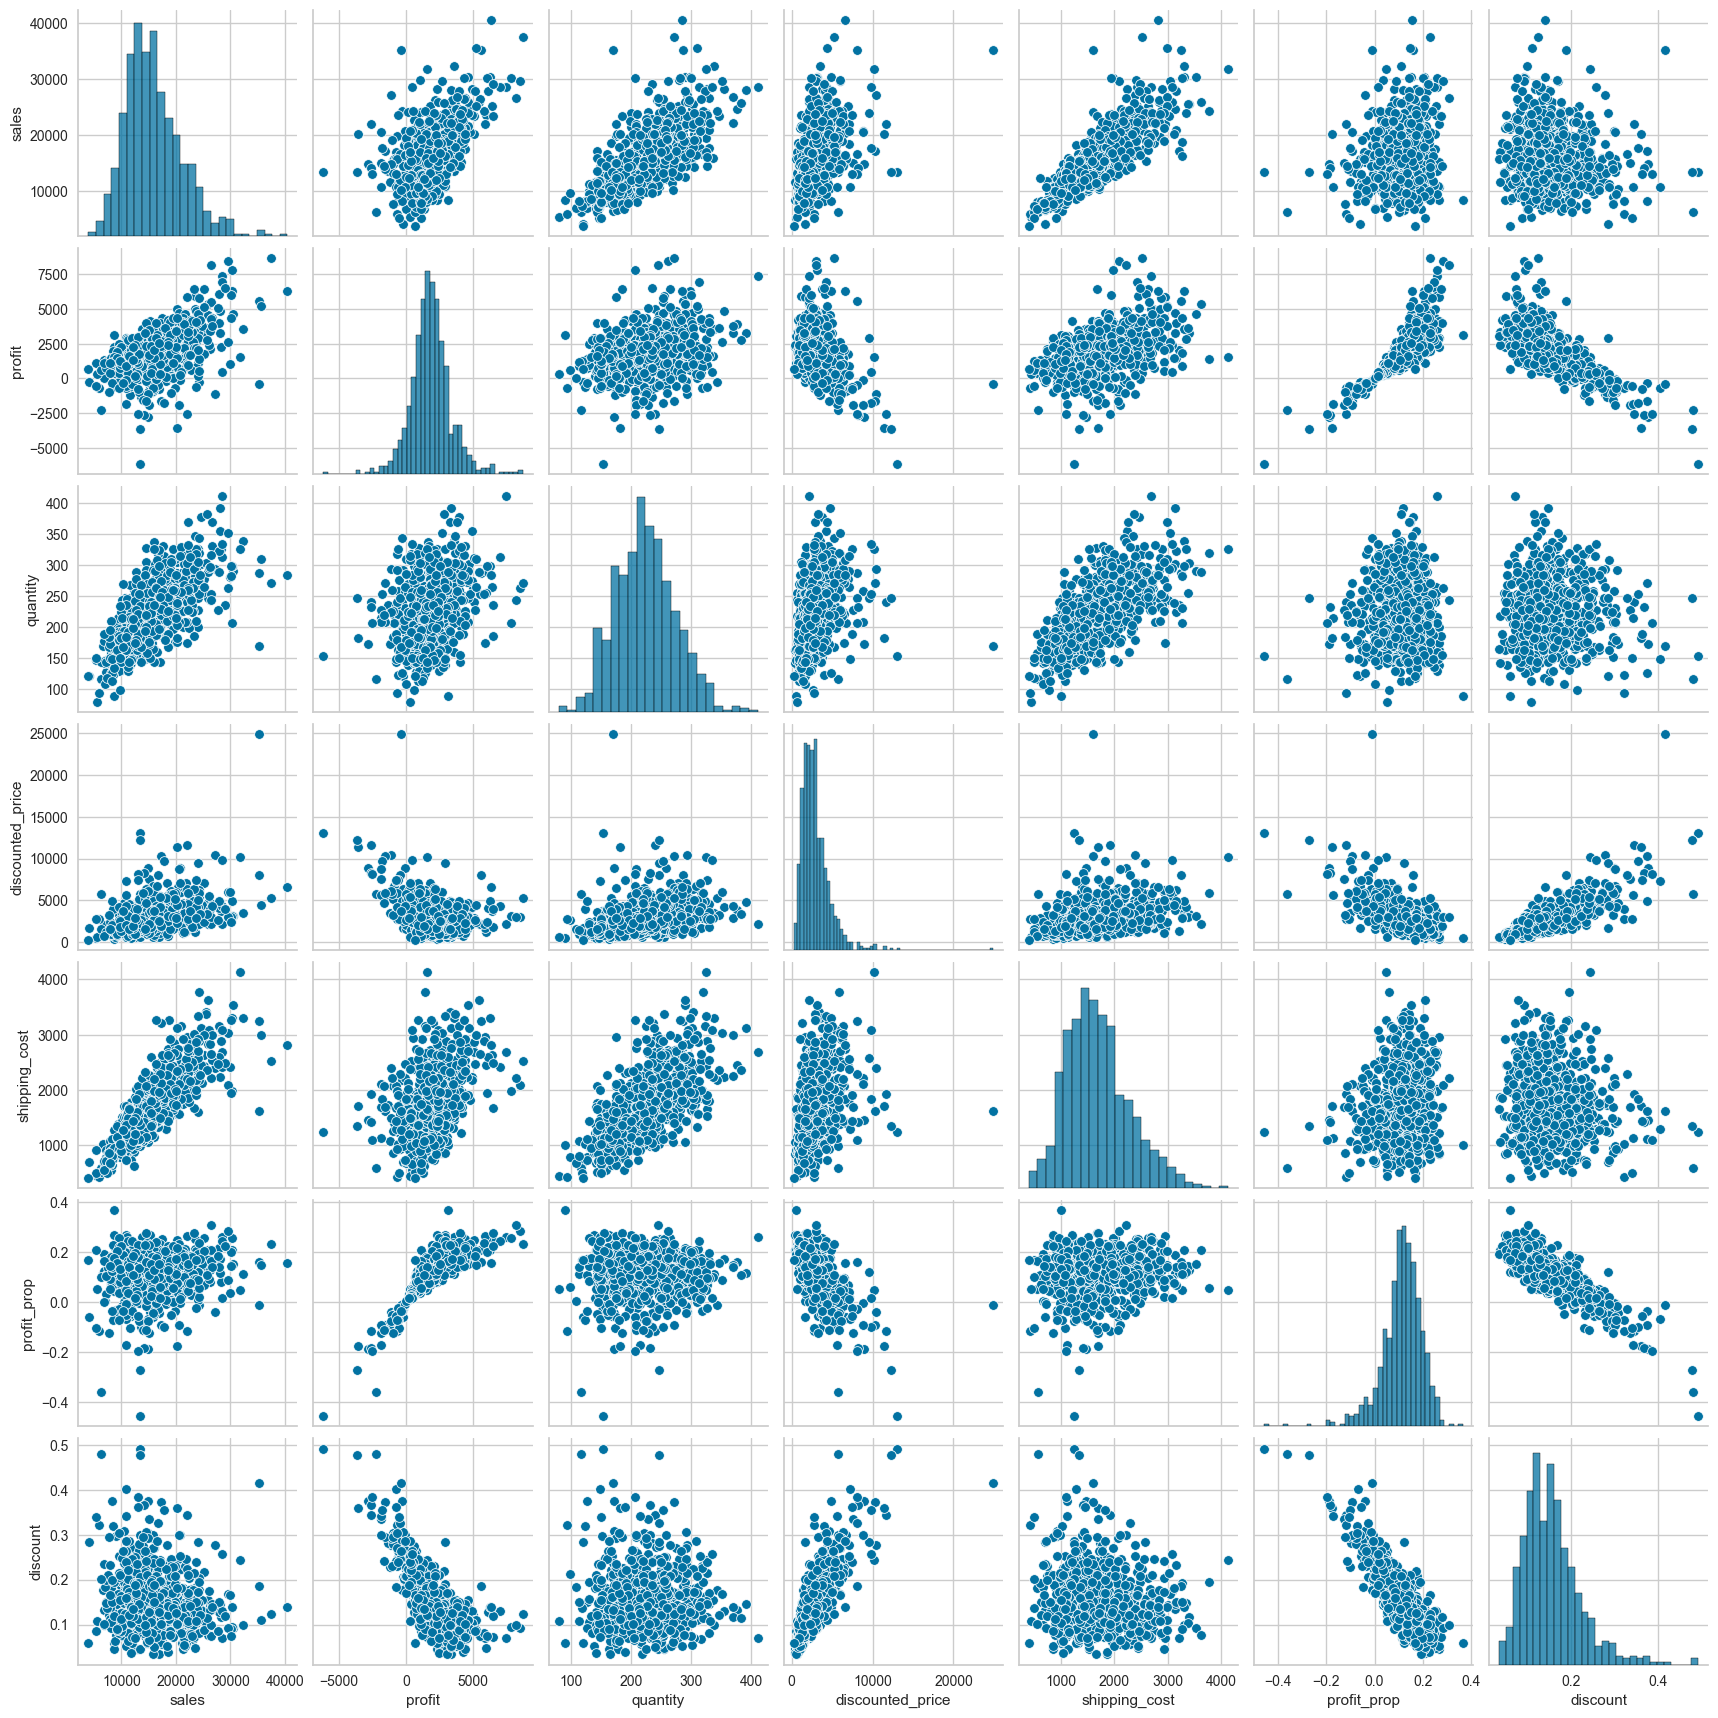

In [219]:
sns.heatmap(customer_sales.corr(numeric_only=True), annot=True)
sns.pairplot(customer_sales)

**Q:** Are heavy discounts dependent on good customers?

Judging from the correlation matrix, revenue ('sales') has no correlation with the average discount applied per customer. Thefore it can be concluded that they are not.

#### 2.2.5.1 Customer 'Segments'

In [220]:
segments_aggregation = (global_superstore.groupby(["segment"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"],
                                                                    discount=lambda df: df["total_discount"]/df["total_profit_before_discount"])
                                                        .sort_values(by="total_profit",ascending=False))


Discount

Discount percentages are equal accross customer segments.

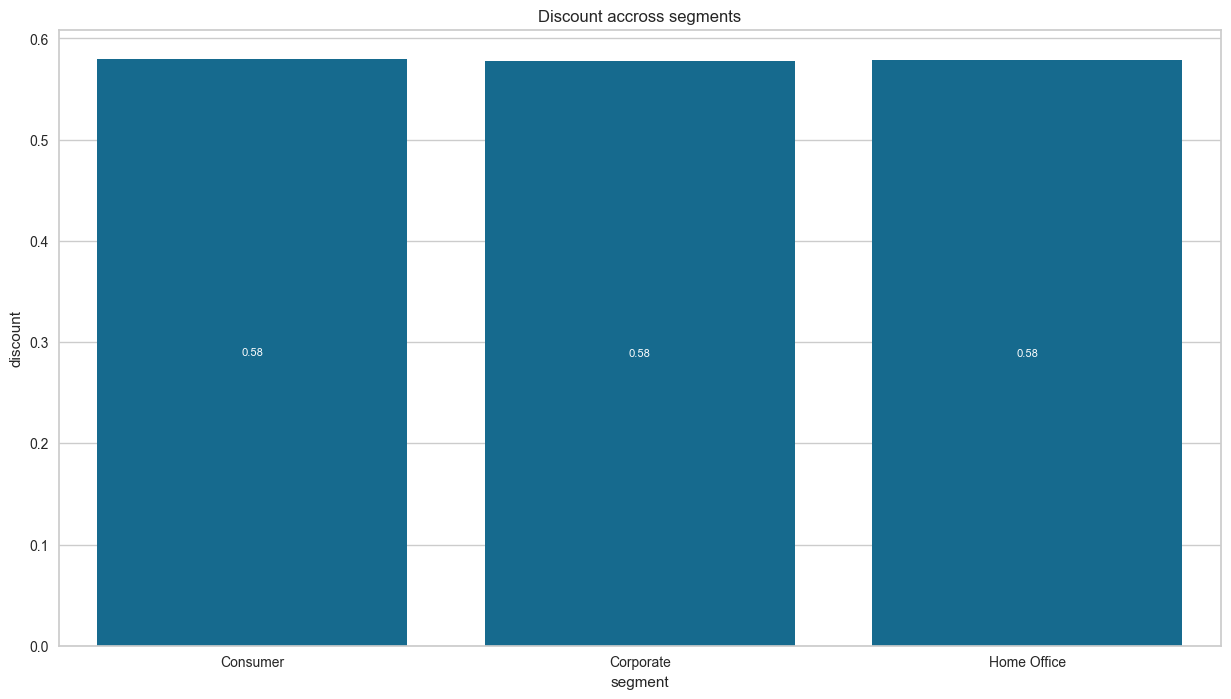

In [222]:
plt.figure(figsize=(15,8))
plt.title("Discount accross segments")
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

Quantities

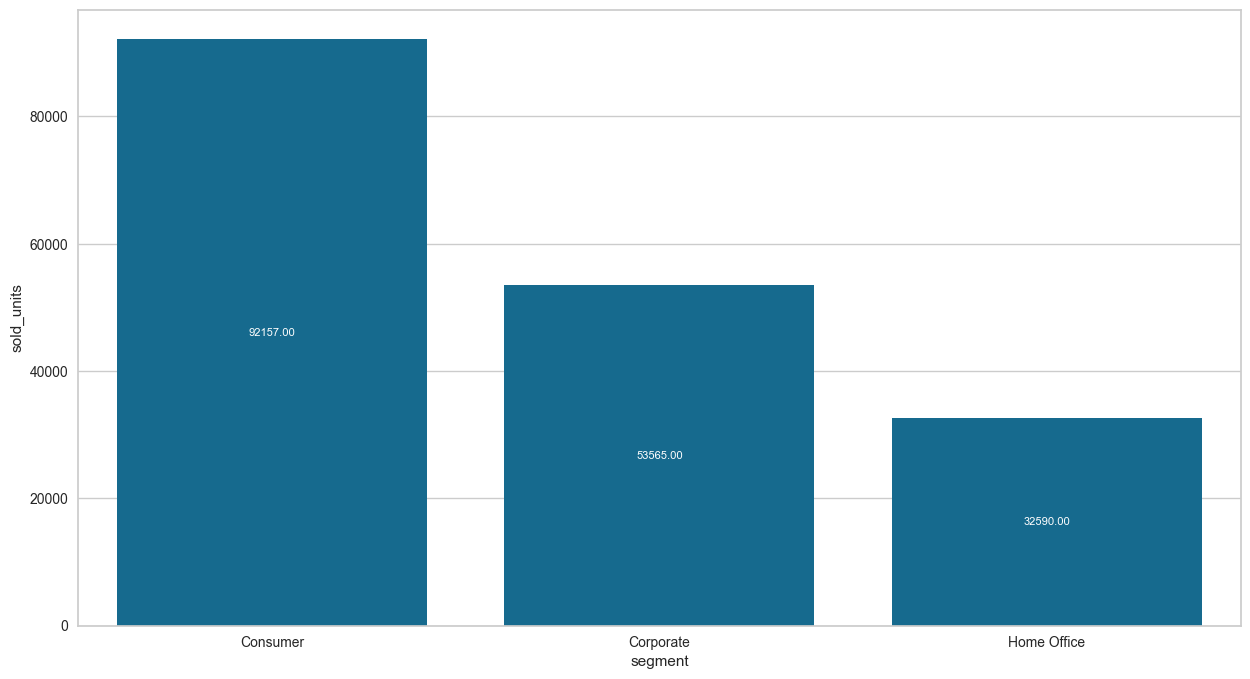

In [156]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="sold_units",
            estimator="sum")
dvs.plot_bar_labels(ax)

Sales

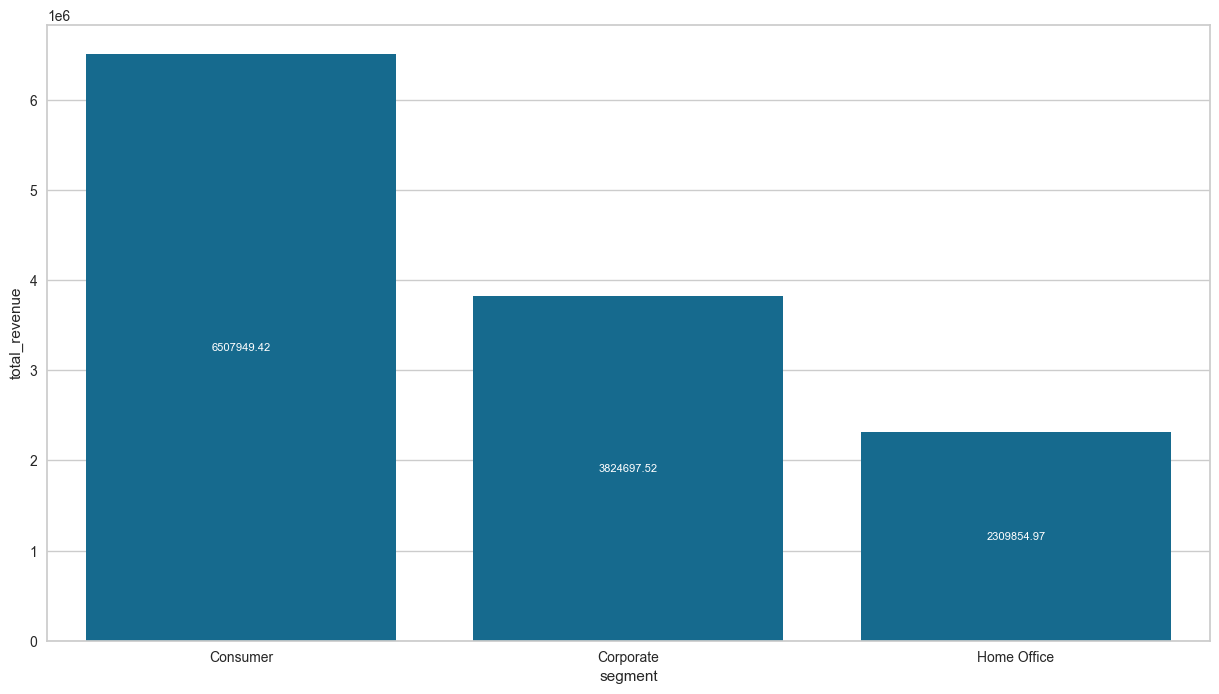

In [157]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

Profit

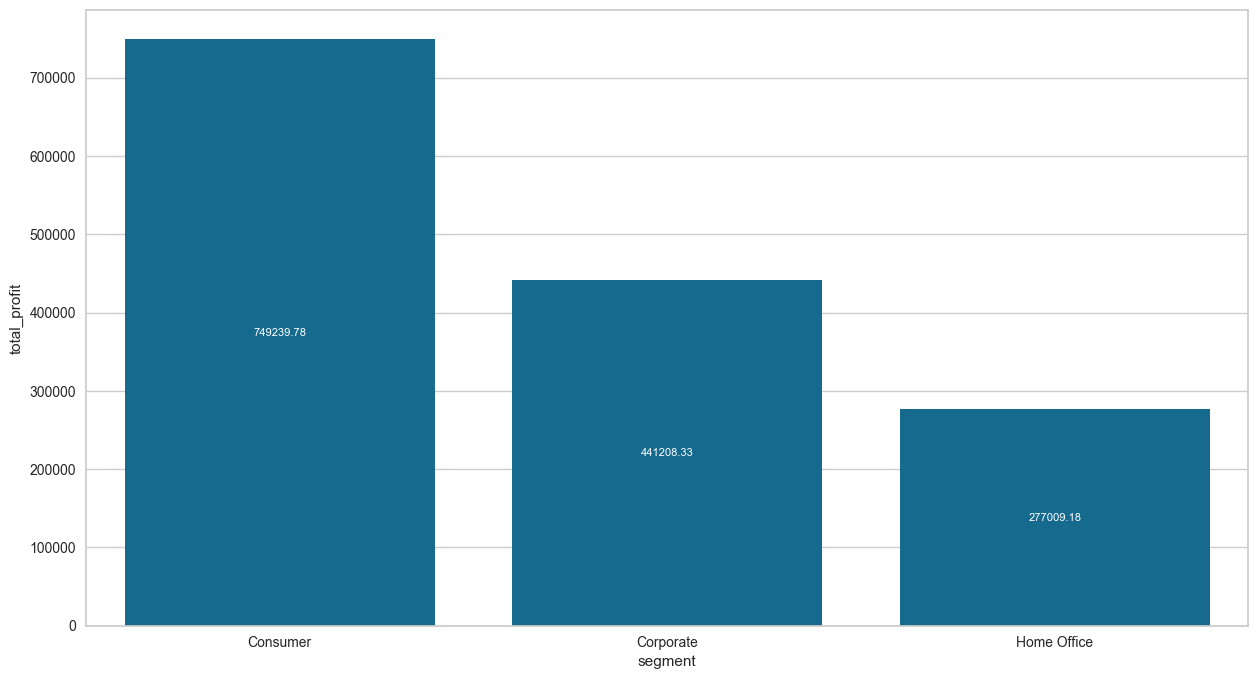

In [158]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="total_profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

Margin

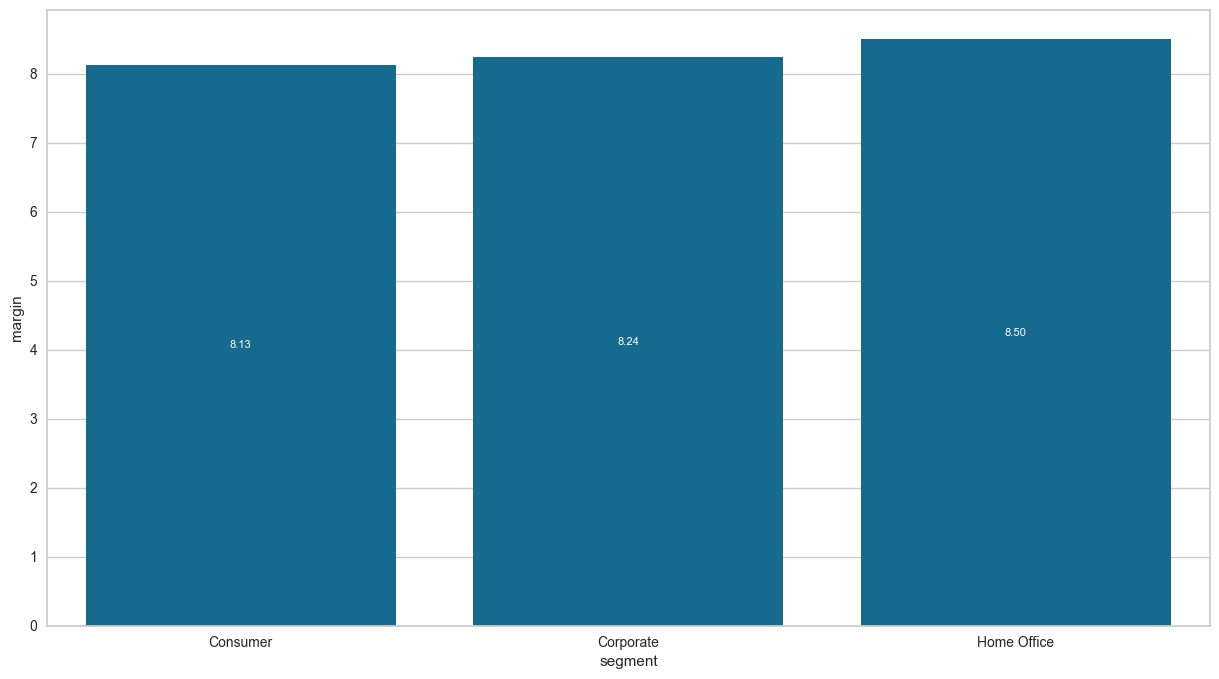

In [159]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="margin",
            estimator="mean")
dvs.plot_bar_labels(ax)

Margin without discount

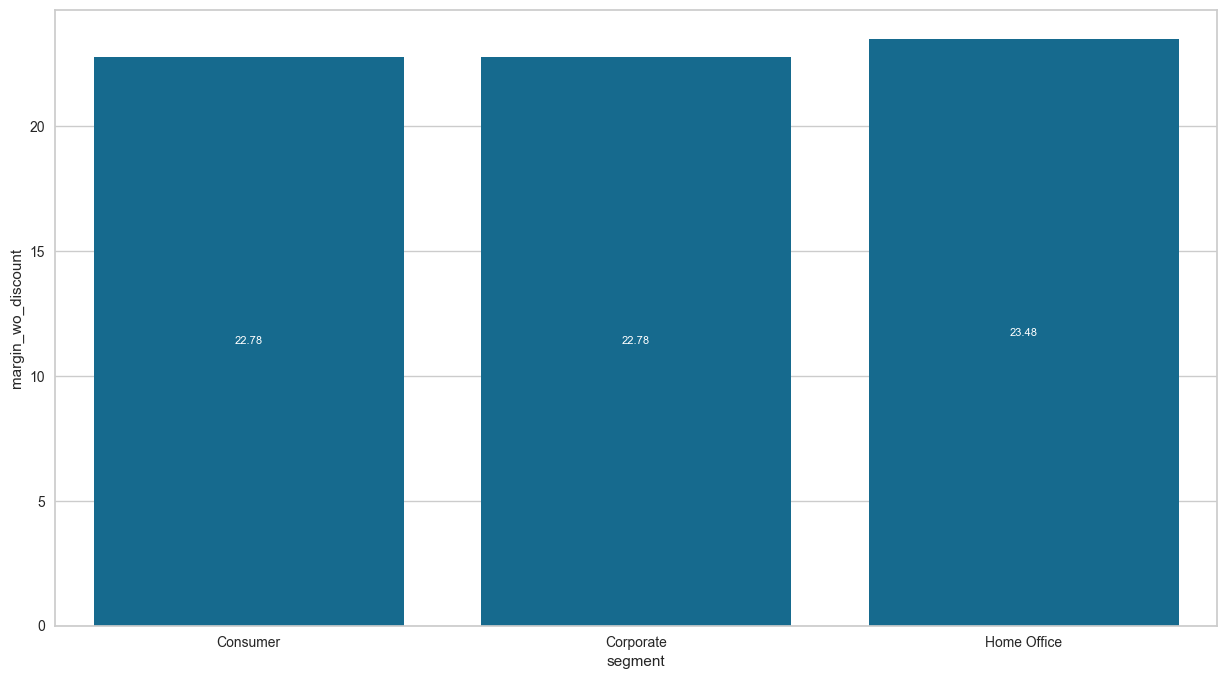

In [160]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="margin_wo_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

## 2.3 Temporal analysis

Calculate monthly metrics

In [229]:
monthly_discounts = global_superstore.set_index("order_date")[["discounted_price","original_price","profit","sales"]].resample("MS").sum()
monthly_discounts["discount"] = monthly_discounts["discounted_price"] / monthly_discounts["original_price"]
monthly_discounts["margin_af_discount"] = monthly_discounts["profit"] / monthly_discounts["sales"]
monthly_discounts = monthly_discounts.to_period("M")
monthly_discounts["order_date"] = monthly_discounts.index.astype("str")
monthly_discounts.head()

discounted_price  original_price       profit         sales  \
order_date                                                                
2011-01          18827.47114       117725.96   8321.80096   98898.48886   
2011-02          16232.37302       107384.53  12417.90698   91152.15698   
2011-03          43692.15264       189421.52  15303.56826  145729.36736   
2011-04          22539.39582       139455.16  12902.32438  116915.76418   
2011-05          29470.73390       176218.57  12183.82870  146747.83610   

            discount  margin_af_discount order_date  
order_date                                           
2011-01     0.159926            0.084145    2011-01  
2011-02     0.151161            0.136233    2011-02  
2011-03     0.230661            0.105014    2011-03  
2011-04     0.161625            0.110356    2011-04  
2011-05     0.167240            0.083026    2011-05

Plot the interaction between % discount and % of profit.

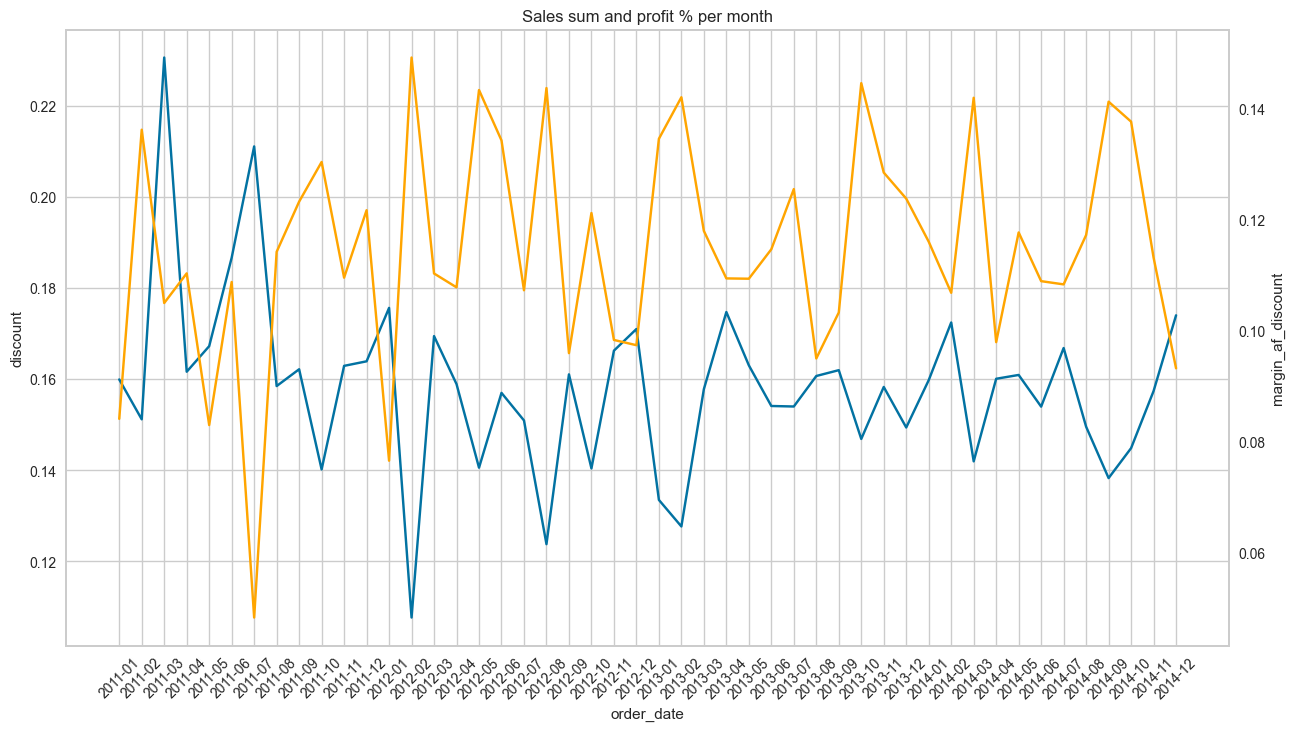

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()

plt.title("Discount % and profit % per month")
sns.lineplot(data=monthly_discounts,
             x="order_date",
             y="discount",
             ax=ax)

sns.lineplot(data=monthly_discounts,
             x="order_date",
             y="margin_af_discount",
             ax=ax2,
             color="orange")

ax.tick_params(axis='x', rotation=45)
plt.grid(False)
plt.show()

Obviously, the higher the average % discount the lower the % of profit or margin after discount. The real question lies in whether that discount manages to drive up absolute profits by driving up sales in revenue. 

Below, the monthly interaction between discounts and sales in revenue + profits.

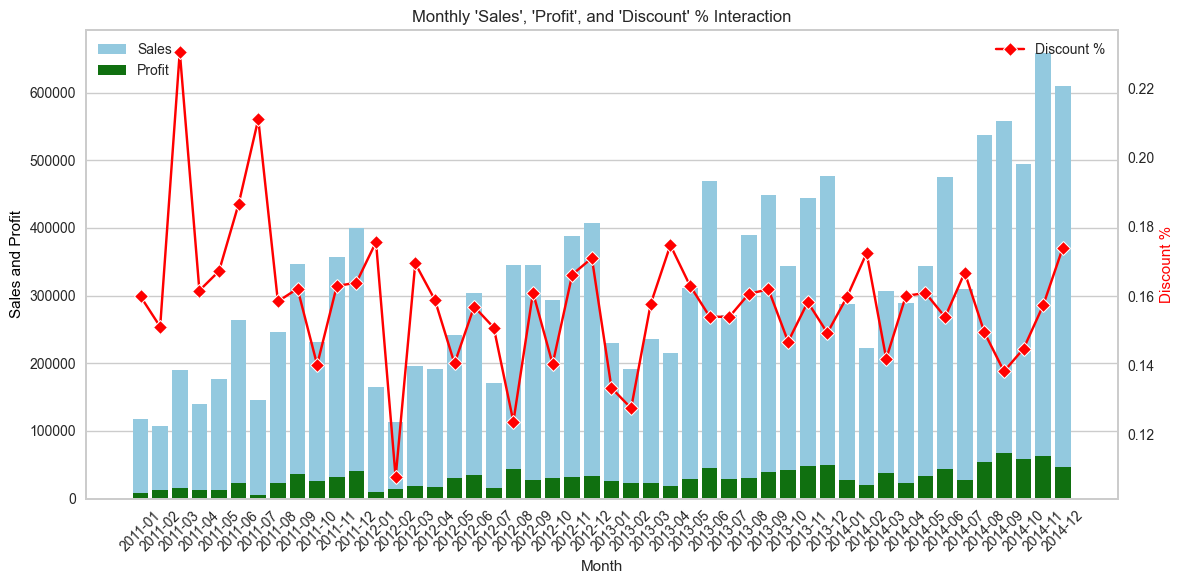

In [226]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barplot for original_price (Sales proxy)
sns.barplot(
    data=monthly_discounts,
    x='order_date', 
    y='original_price', 
    ax=ax1, 
    color='skyblue', 
    label='Sales'
)

# Lineplot for Profit on the same axis
sns.barplot(
    data=monthly_discounts,
    x="order_date",
    y="profit",
    ax=ax1,
    color="green",
    label="Profit"
)
# ax1 title
ax1.set_title("Monthly 'Sales', 'Profit', and 'Discount' % Interaction")

# Secondary axis for Discount
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_discounts,
    x="order_date",
    y="discount",
    ax=ax2,
    color='red', 
    marker='D', 
    linestyle='-', 
    label='Discount %'
)

# Axis lables
ax1.set_ylabel('Sales and Profit', color='black')
ax2.set_ylabel('Discount %', color='red')
ax1.set_xlabel('Month')


# Rotate x-axis 
ax1.set_xticks(range(len(monthly_discounts)))
ax1.set_xticklabels(monthly_discounts['order_date'], rotation=45)

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(False) 
plt.tight_layout()
plt.show()


In the beginning of the time series, given the amount of revenue, it can be inferred that it was the time when Global Superstore was starting its activity. Discount percentages were high and that could have helped drive up sales.

However, after sales start to rise and % of discount stabilise, sales do not seem to increase when percentages of discount increase. Rather, there are periods when sales are down and the percentage of discount is low too, for example 2012-01 and 2013-01. Loss of revenue cannot be attributed to low discount percentages because before or after those moments, sales where low when discounts were high and viceversa.

To numerically check this, let us calculate and visually inspect the correlation between sales and discounts.

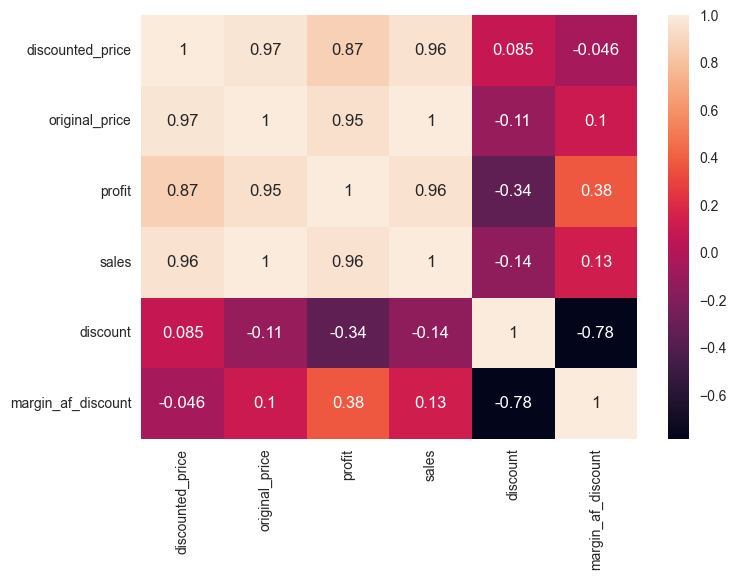

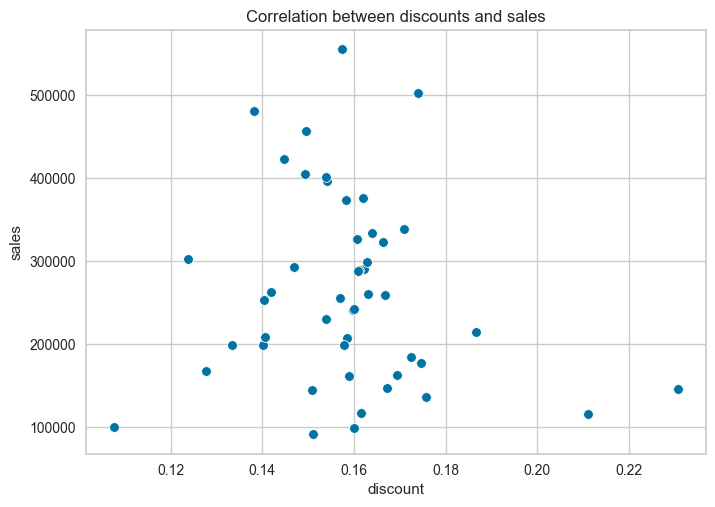

In [243]:
sns.heatmap(monthly_discounts.corr(numeric_only=True, method="spearman"),annot=True)
plt.show()

plt.title("Correlation between discounts and sales")
sns.scatterplot(data=monthly_discounts,
                x="discount",
                y="sales")
plt.show()

As suspected, monthly data of discount percentages and revenue show no correlation.

# 3. Conclusion and insights